<a href="https://colab.research.google.com/github/arpanbiswas52/varTBO/blob/main/BO_spectral_cleancopy_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral optimization through BO with adaptive target setting

- Problem domain expert - Rama Vasudevan
- BO modeling -- Arpan Biswas

#Problem Description

Build a BO framework-

- Here we have a image data, where X is the input location of the image

- Each location in the image, we have a spectral data, from where user select if the data is good/bad (discrete choice). We take the means of all good loops only to generate the target loop.

- The goal is to build a optimization (BO) model where we adaptively sample towards region (in image) of good spectral, and find optimal location point closest to the current chosen target spectral (as per user voting). 



Install packages

In [1]:
#@title
#!pip install atomai
#!pip install -q pyroved kornia
!pip install botorch #version 0.5.1
!pip install gpytorch #version 1.6.0
!pip install smt
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 5.1 MB/s 
     |████████████████████████████████| 361 kB 57.7 MB/s 
     |████████████████████████████████| 718 kB 66.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smt: filename=smt-1.3.0-cp37-cp37m-linux_x86_64.whl size=528024 sha256=cd8953ff1fc136e2fe35c6a949098857cec5eb90e329cfadecf2632ae7198554
  Stored in directory: /root/.cache/pip/wheels/e1/5b/7b/a60bcc2b0411788df670d0059b80599c9644e922dab40a6bc4
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256

Import library

In [ ]:
#@title 
import torch
from torchvision import datasets, transforms
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
import streamlit as st
#import kornia as K
#import kornia.metrics as metrics
from PIL import Image
from typing import Tuple
import ipywidgets as widgets
from IPython.display import display
import pylab as pl
from IPython.display import clear_output
import pdb
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import gpim
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from copy import deepcopy
#import pyroved as pv
#import atomai as aoi
from typing import Union
import pickle


# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
#from botorch.models import gpytorch
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan

from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions

from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
from scipy.interpolate import interp1d

# Run this hidden cell first which is the coded BO framework 

In [ ]:
#@title
##@title objective function evaluation- We maximize the similarity index(negative mse) between target and sampled spectral and maximize the reward as per user voting of sampled spectral
def func_obj(X, spec_norm, V, wcount_good, target_func, vote):
    idx1 = int(X[0, 0])
    idx2 = int(X[0, 1])
    rf = 1
    if (wcount_good == 0): #We dont find a good loop yet from all initial sampling and thus target is unknown
        mse_spectral = torch.rand(1)*(1)+1 # Unif[1, 2] A sufficiently large value as we want to avoid selecting bad loops,
        # When we have a target, we will recalculate again to get more accuract estimate
        R = vote*rf
      
    else:
        #Calculate dissimilarity (mse) between target and ith loop shape
        dev2_spectral = (target_func-spec_norm[idx1, idx2, :])**2
        mse_spectral = torch.mean(dev2_spectral)
        #Calculate reward as per voting, this will minimize the risk of similar function values of good and bad loop shape with similar mse
        R = vote*rf
    
    #This is the basic setting of obj func-- we can incorporate more info as per domain knowledge to improve
    #Into maximization problem
    obj = R - mse_spectral #Maximize reward and negative mse

    return obj

##@title generate/update target loop
def generate_targetobj(X, spec_norm, lowres_image, V, wcount_good, target_func):
    #count_good= 0
    idx1 = int(X[0, 0])
    idx2 = int(X[0, 1])
    #print(idx1, idx2)
    #target_loop = torch.empty(loop_norm.shape[2])
    if (wcount_good == 0):
    # Figure for user choice
        fig,ax=plt.subplots(ncols=2,figsize=(12,4))
        ax[0].plot(V,spec_norm[idx1, idx2, :])
        ax[0].set_title('loc:' +str(idx1) +"," + str(idx2))
        ax[1].imshow(lowres_image.detach().numpy())
        ax[1].plot(idx1, idx2, 'x', color="red")
        plt.show()

    else:
    # Figure for user choice
        fig,ax=plt.subplots(ncols=3,figsize=(12,4))
        ax[0].plot(V,spec_norm[idx1, idx2, :])
        ax[0].set_title('loc:' +str(idx1) +"," + str(idx2))
        ax[1].imshow(lowres_image.detach().numpy())
        ax[1].plot(idx1, idx2, 'x', color="red")
        ax[2].plot(V,target_func)
        ax[2].set_title('Current target function')
        plt.show()

    print("Rating: 0-Bad, 1-Good, 2-Very good")
    vote = float(input("enter rating: "))
    if(vote>0):
        newspec_wt = 1
        if ((wcount_good) > 0): #Only if we already have selected good spectral in early iterations
            newspec_pref = str(input("Do you want to update preference to new spectral over prioir mean target (Y/N): "))
            if (newspec_pref == 'Y'):
                print("Provide weights between 0 and 1: 1 being all the weights to new spectral as new target")
                newspec_wt = float(input("enter weightage: "))
            else:
                newspec_wt = 0.5
        wcount_good =wcount_good + vote
        target_func = (((1-newspec_wt)*target_func*(wcount_good-vote))\
                       + (newspec_wt*vote*spec_norm[idx1, idx2, :]))/(((wcount_good-vote)*(1-newspec_wt))\
                       + (vote*newspec_wt))
    return vote, wcount_good, target_func


class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        #self.mean_module = LinearMean(train_X.shape[-1])
        self.covar_module = ScaleKernel(
            #base_kernel=MaternKernel(nu=2.5, ard_num_dims=train_X.shape[-1]),
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

#Optimize Hyperparameters of GP#
def optimize_hyperparam_trainGP(train_X, train_Y):
    # Gp model fit

    gp_surro = SimpleCustomGP(train_X, train_Y)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood, gp_surro)
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X)
    gp_surro.train()
    gp_surro.likelihood.train()
    ## Here we use Adam optimizer with learning rate =0.1, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.parameters()}], lr=0.1) #0.01 set for BEPFM data, recommended to check the lr for any new data
    #optimizer1 = SGD([{'params': gp_surro.parameters()}], lr=0.0001)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro(train_X)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss:" + str(loss1.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise:" + str(gp_surro.likelihood.noise.item()))


        optimizer1.step()

    gp_surro.eval()
    gp_surro.likelihood.eval()
    return gp_surro


#GP posterior predictions#
def cal_posterior(gp_surro, test_X):
    y_pred_means = torch.empty(len(test_X), 1)
    y_pred_vars = torch.empty(len(test_X), 1)
    t_X = torch.empty(1, test_X.shape[1])
    for t in range(0, len(test_X)):
        with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
            gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                      solves=True), \
            gpt.settings.max_cg_iterations(100), \
            gpt.settings.max_preconditioner_size(80), \
            gpt.settings.num_trace_samples(128):

                t_X[:, 0] = test_X[t, 0]
                t_X[:, 1] = test_X[t, 1]
                #t_X = test_X.double()
                y_pred_surro = gp_surro.posterior(t_X)
                y_pred_means[t, 0] = y_pred_surro.mean
                y_pred_vars[t, 0] = y_pred_surro.variance

    return y_pred_means, y_pred_vars


#EI acquistion function#
def acqmanEI(y_means, y_vars, train_Y, ieval):


    y_means = y_means.detach().numpy()
    y_vars = y_vars.detach().numpy()
    y_std = np.sqrt(y_vars)
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    EI_val = np.zeros(len(y_vars))
    Z = np.zeros(len(y_vars))
    eta = 0.01
    
    for i in range(0, len(y_std)):
        if (y_std[i] <=0):
            EI_val[i] = 0
        else:
            Z[i] =  (y_means[i]-best_value-eta)/y_std[i]
            EI_val[i] = (y_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_std[i]*norm.pdf(Z[i])

    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    EI_val[ieval] = -1
    acq_val = np.max(EI_val)
    acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
    #print(acq_val)
    return acq_cand, acq_val, EI_val


# Normalize all data. It is very important to fit GP model with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X.
def normalize_get_initialdata_KL(X, fix_params, num, m):
    
    X_feas = torch.empty((X.shape[1]**X.shape[0], X.shape[0]))
    k=0
    spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
    for t1 in range(0, X.shape[1]):
        for t2 in range(0, X.shape[1]):
            X_feas[k, 0] = X[0, t1]
            X_feas[k, 1] = X[1, t2]
            k=k+1
    
    X_feas_norm = torch.empty((X_feas.shape[0], X_feas.shape[1]))
    #train_X = torch.empty((len(X), num))
    #train_X_norm = torch.empty((len(X), num))
    train_Y = torch.empty((num, 1))
    pref = torch.empty((num, 1))
   

    # Normalize X
    for i in range(0, X_feas.shape[1]):
        X_feas_norm[:, i] = (X_feas[:, i] - torch.min(X_feas[:, i])) / (torch.max(X_feas[:, i]) - torch.min(X_feas[:, i]))
      
    

    # Select starting samples randomly as training data
    np.random.seed(0)
    idx = np.random.randint(0, len(X_feas), num)
    train_X = X_feas[idx]
    train_X_norm = X_feas_norm[idx]
    #print(train_X)
    #print(train_X_norm)

    #Evaluate initial training data
    x = torch.empty((1,2))
    # First generate target loop, based on initial training data
    wcount_good= 0
    target_func = torch.zeros(spec_norm.shape[2])
    for i in range(0, num):
        x[0, 0] = train_X[i, 0]
        x[0, 1] = train_X[i, 1]
        print("Sample #" + str(m + 1))
        pref[i, 0], wcount_good, target_func = generate_targetobj(x, spec_norm, lowres_image, V, wcount_good, target_func)
        m = m + 1

    # Once target loop is defined (unless are loops are selected bad by user), we compute the obj
    for i in range(0, num):
        x[0, 0] = train_X[i, 0]
        x[0, 1] = train_X[i, 1]

        #print("Function eval #" + str(m + 1))

        train_Y[i, 0] = func_obj(x, spec_norm, V, wcount_good, target_func, pref[i, 0])
        #m = m + 1
    #print(pref)
    #print(train_Y)
    var_params = [wcount_good, pref, target_func]
    
    return X_feas, X_feas_norm, train_X, train_X_norm, train_Y, var_params, idx, m


################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_KL(acq_X, acq_X_norm, train_X, train_X_norm, train_Y, fix_params, var_params, m):
    spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
    wcount_good, pref, target_func = var_params[0], var_params[1], var_params[2]

    nextX = acq_X
    nextX_norm = acq_X_norm
    #train_X_norm = torch.cat((train_X_norm, nextX_norm), 0)
    #train_X_norm = train_X_norm.double()
    train_X_norm = torch.vstack((train_X_norm, nextX_norm))
    train_X = torch.vstack((train_X, nextX))
    
    p = torch.empty(1, 1)
    x = torch.empty((1,2))
    x[0, 0] = train_X[-1, 0]
    x[0, 1] = train_X[-1, 1]

    print("Sample #" + str(m + 1))
    #Vote for new spectral sample and update(or not) target spectral function
    p[0, 0], wcount_good, target_func = generate_targetobj(x, spec_norm, lowres_image, V, wcount_good, target_func)
    pref = torch.vstack((pref, p)) #Augment pref matrix
    
    if (p[0, 0] == 0):
      # If target loop is not updated, we eval for the new samples only as the func value for others remain the same

        next_feval = torch.empty(1, 1)
        next_feval[0, 0] = func_obj(x, spec_norm, V, wcount_good, target_func, pref[-1, 0])
        train_Y = torch.vstack((train_Y, next_feval))
    else:
        # If target loop is updated, we reevaluate the obj of old spectral samples and eval for the new samples
        train_Y = torch.empty((train_X.shape[0], 1))
        for i in range(0, train_X.shape[0]):
            x[0, 0] = train_X[i, 0]
            x[0, 1] = train_X[i, 1]
            train_Y[i, 0] = func_obj(x, spec_norm, V, wcount_good, target_func, pref[i, 0])

    
    #print(pref)
    #print(train_Y)
    var_params = [wcount_good, pref, target_func]
    m = m + 1
    return train_X, train_X_norm, train_Y, var_params, m

##@title Functions to plot KL trajectories at specific BO iterations (Need to revise)
def plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i):
    spec_norm, lowres_image, V  = fix_params[0], fix_params[1], fix_params[2]
    pen = 10**0
    #Best solution among the evaluated data
    
    loss = torch.max(train_Y)
    ind = torch.argmax(train_Y)
    X_opt = torch.empty((1,2))
    #X_opt = train_X[ind, :]
    X_opt[0, 0] = train_X[ind, 0]
    X_opt[0, 1] = train_X[ind, 1]


    # Best estimated solution from GP model considering the non-evaluated solution

    loss = torch.max(y_pred_means)
    ind = torch.argmax(y_pred_means)
    X_opt_GP = torch.empty((1,2))
    #X_opt = train_X[ind, :]
    X_opt_GP[0, 0] = test_X[ind, 0]
    X_opt_GP[0, 1] = test_X[ind, 1]

    #Objective map
    plt.figure()

    fig,ax=plt.subplots(ncols=3,figsize=(12,4))
    a= ax[0].imshow(lowres_image.detach().numpy(), origin="lower")
    ax[0].scatter(train_X[:,0], train_X[:,1], marker='o', c='g')
    ax[0].scatter(X_opt[0, 0], X_opt[0, 1], marker='x', c='r')
    ax[0].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')


    a = ax[1].scatter(test_X[:,0], test_X[:,1], c=y_pred_means/pen, cmap='viridis', linewidth=0.2)
    ax[1].scatter(train_X[:,0], train_X[:,1], marker='o', c='g')
    ax[1].scatter(X_opt[0, 0], X_opt[0, 1], marker='x', c='r')
    ax[1].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(a, cax=cax, orientation='vertical')
    ax[1].set_title('Objective (GP mean) map')
    #ax[1].colorbar(a)

    b = ax[2].scatter(test_X[:,0], test_X[:,1], c=y_pred_vars/(pen**2), cmap='viridis', linewidth=0.2)
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(b, cax=cax, orientation='vertical')
    ax[2].set_title('Objective (GP var) map')
    #ax[2].colorbar(b)
    plt.show()
    

    return X_opt, X_opt_GP

#BO framework integration
def BO_vartarget(X, fix_params, num_start, N):
    num = num_start
    m = 0
    # Initialization: evaluate few initial data normalize data
    test_X, test_X_norm, train_X, train_X_norm, train_Y, var_params, idx, m = \
        normalize_get_initialdata_KL(X, fix_params, num, m)


    print("Initial evaluation complete. Start BO")
    ## Gp model fit
    # Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

    for i in range(1, N + 1):
        # Calculate posterior for analysis for intermidiate iterations
        y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X_norm)
        if ((i == 1) or ((i % 10) == 0)):
            # Plotting functions to check the current state exploration and Pareto fronts
            X_eval, X_GP = plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i)

        #print(idx)
        acq_cand, acq_val, EI_val = acqmanEI(y_pred_means, y_pred_vars, train_Y, idx)
        val = acq_val
        ind = np.random.choice(acq_cand) # When multiple points have same acq values
        idx = np.hstack((idx, ind))


        ################################################################
        ## Find next point which maximizes the learning through exploration-exploitation
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            nextX = torch.empty((1, len(X)))
            nextX_norm = torch.empty(1, len(X))
            nextX[0,:] = test_X[ind, :]
            nextX_norm [0, :] = test_X_norm[ind, :]

            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, var_params, m =\
             augment_newdata_KL(nextX, nextX_norm, train_X, train_X_norm,train_Y, fix_params, var_params, m)

            # Gp model fit
            # Updating GP with augmented training data
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Optimal GP learning
    gp_opt = gp_surro
    # Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_opt, test_X_norm)
    # Plotting functions to check final iteration
    X_opt, X_opt_GP = plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_params, i)
    explored_data = [train_X, train_Y]
    final_GP_estim = [y_pred_means, y_pred_vars]
    user_votes = var_params[1]
    optim_results = [X_opt, X_opt_GP, user_votes, explored_data]

    #Save few data
    np.save("optim_results", optim_results)


    return  X_opt, X_opt_GP, var_params, explored_data, final_GP_estim

#Load data for analysis - BEPFM data

In [ ]:
!pip install -U gdown
#!gdown "https://drive.google.com/uc?id=1Rysso5x9Mnhwddt48txKJ9400q5XoAtl"
!gdown "https://drive.google.com/uc?id=1PoklVNuIwhAMbig0LvxW-zAK82et_aL-"
!gdown "https://drive.google.com/uc?id=11v5wHmMT0xYcxAYejjxLKz1QARST_JRn"
!gdown "https://drive.google.com/uc?id=1jQZIW7uiNV0J-mDl1yNylhNA6rRFnMM4"


#boptim_results = np.load("boptim_results.npy", allow_pickle=True)
loop_mat = np.load("loop_mat.npy")
dc_vec = np.load("dc_vec.npy")
bepfm_image = np.load("bepfm_image.npy")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14951 sha256=581f5b38d66454741227f9b50e7b32bc9bc1d210be8efe29314949ede0306058
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1PoklVNuIwhAMbig0LvxW-zAK82et_aL-
To: /content/loop_mat.npy
100% 2.76M/2.76M [00:00<00:00, 208MB/s]
Downloading...
From: https://drive.google.com/uc?id=11v5wHmMT0xYcxAYejjxLKz1QARST_JRn
To: /content/dc_vec.npy
100% 896/896 [00:00<00:00, 1.62MB/s]
Downloading...
From: https://drive.google.com/uc

# Run below hidden cell for data preparation to start BO

In [ ]:
#@title
n_spectral = 2 # Consider the final loop measurement
loop_mat_grid = np.reshape(loop_mat,(60, 60, loop_mat.shape[1], loop_mat.shape[2]))
loop = loop_mat_grid[:, :, :, n_spectral] 
#print(loop.shape)

#Tranform the image data to map with spectral data
grid_dim = loop.shape[1]
bepfm_lowres_image = resize(bepfm_image, (grid_dim, grid_dim))
#print(bepfm_lowres_image.shape)

#Consider single sweep of voltage to generate hysteresis loop
l_vsweep= loop.shape[2]
V= dc_vec[:l_vsweep]
#print(V.shape)

#Normalize loop data (avoiding drift in data)
loop_norm = np.zeros((loop.shape))
for i in range(0, loop.shape[0]):
  for j in range(0, loop.shape[1]):
    loop_norm[i, j, :] = (loop[i,j,:]- np.mean(loop[i,j,:]))*1e4

#print(loop.shape, loop_norm.shape)

#tranform data into torch
loop_norm = torch.from_numpy(loop_norm)
V = torch.from_numpy(V)
bepfm_lowres_image= torch.from_numpy(bepfm_lowres_image)

#print(loop_norm.shape, bepfm_lowres_image.shape, V.shape)

Run BO to find the optimal location for best spectral (hysteresis loop) as voted by user

- Here we vote the quality of spectral as trying to get a greater loop area, with minimal noise and be as much towards theoritical hysteresis loop.

- After BO run, the code automatically save below data (serially) in optim.results.npy

  1. Best locations, from evaluated and GP estimated

  2. votes gives by users for each evaluated locations

  3. the matrices of evaluated location and the respective obj values

Sample #1


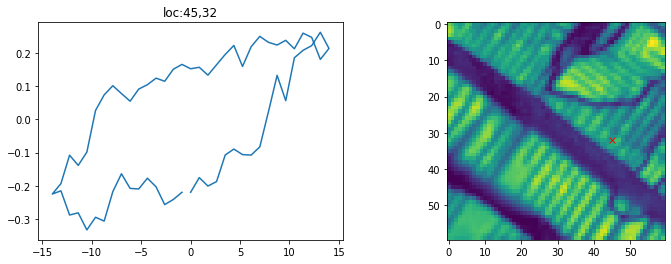

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Sample #2


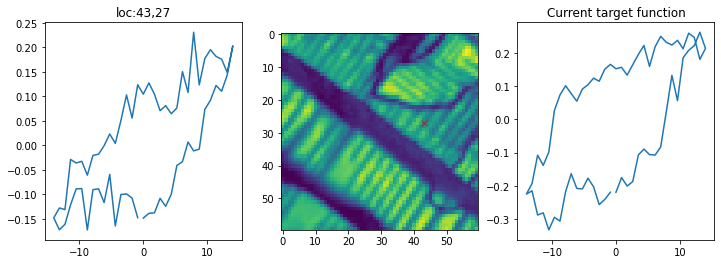

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #3


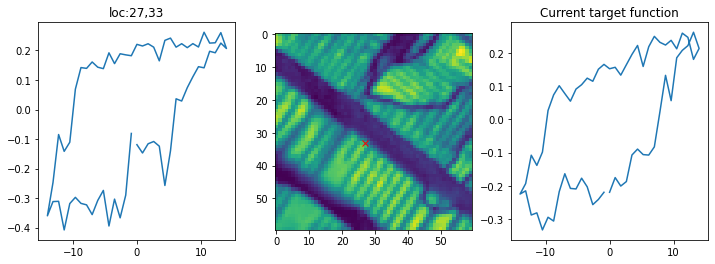

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 1
Sample #4


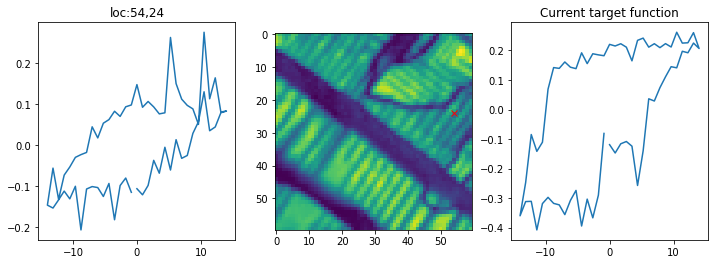

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #5


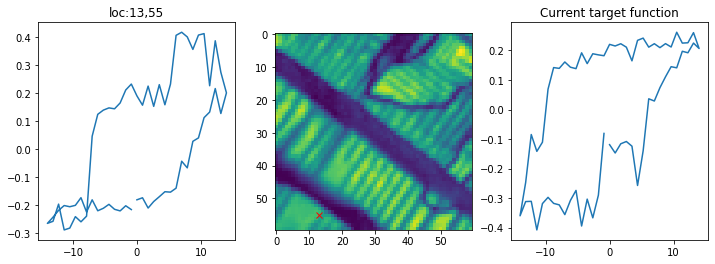

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Initial evaluation complete. Start BO


/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


<Figure size 432x288 with 0 Axes>

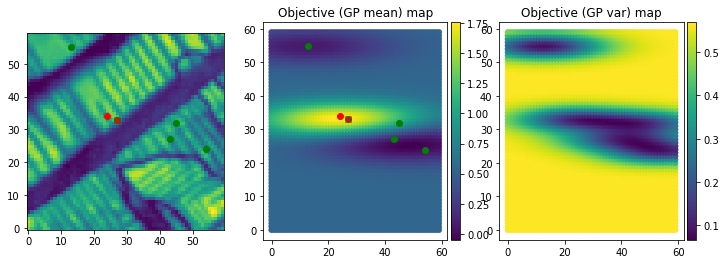

Sample #6


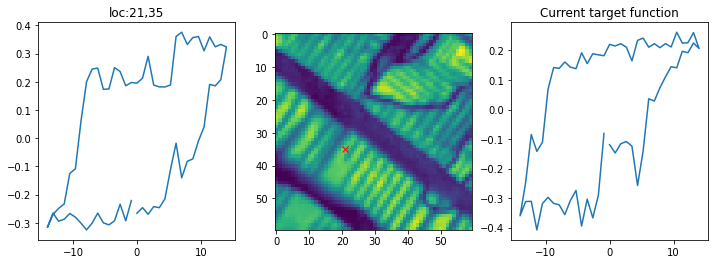

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #7


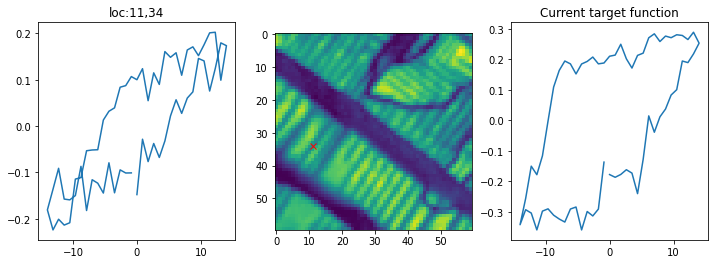

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #8


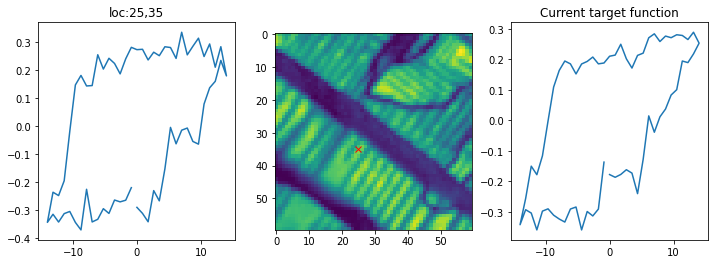

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #9


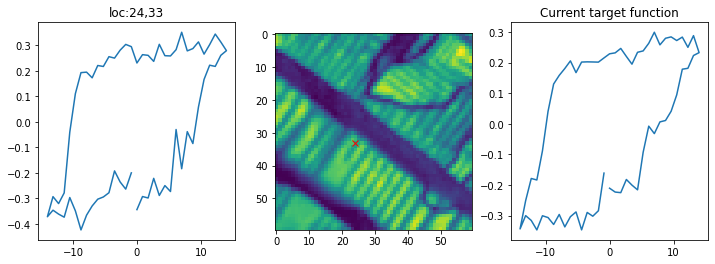

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #10


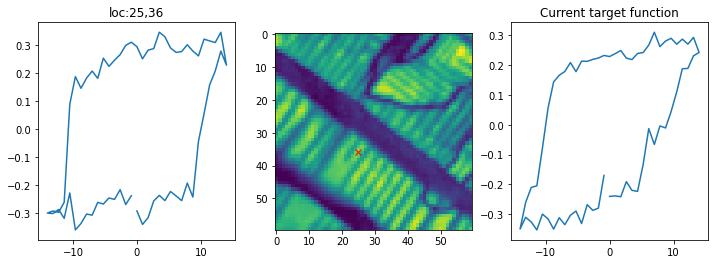

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #11


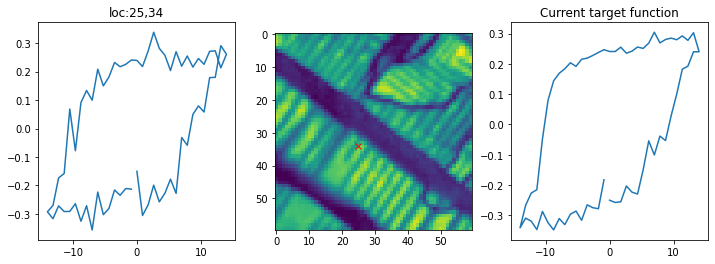

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #12


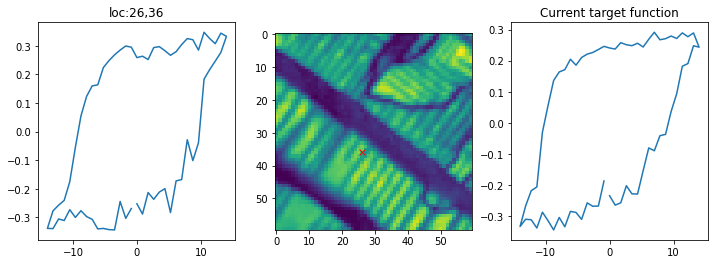

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #13


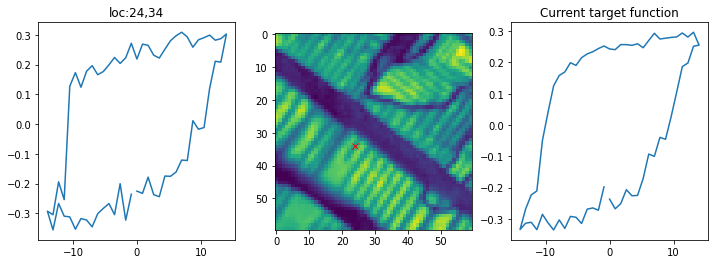

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #14


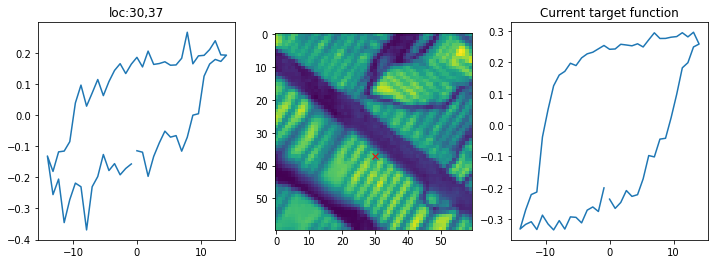

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

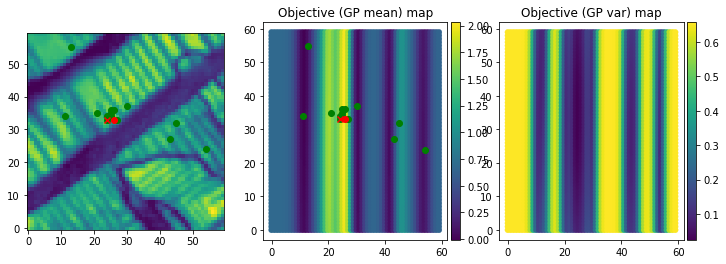

Sample #15


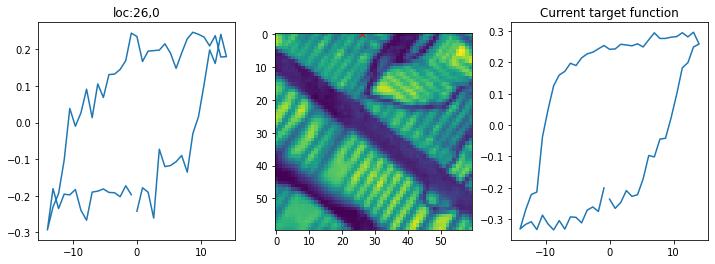

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #16


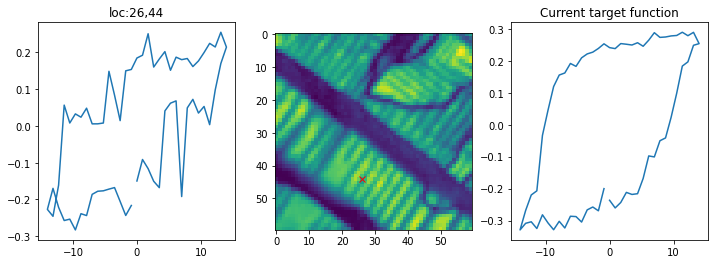

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #17


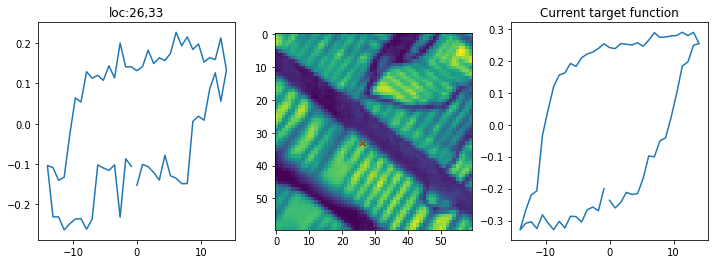

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #18


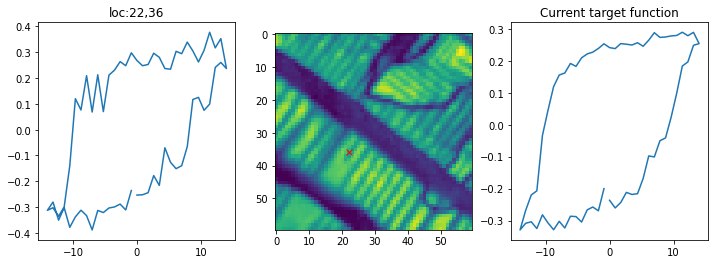

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #19


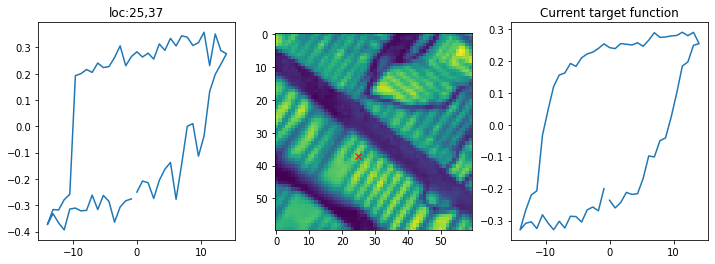

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #20


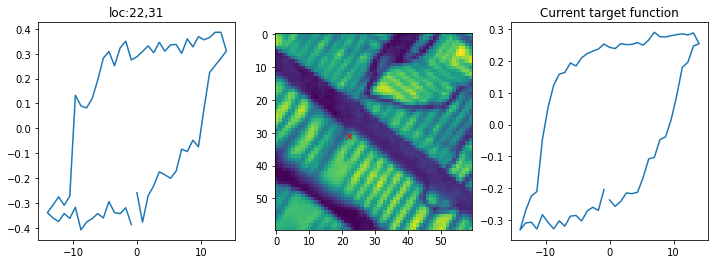

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Max. sampling reached, model stopped


<Figure size 432x288 with 0 Axes>

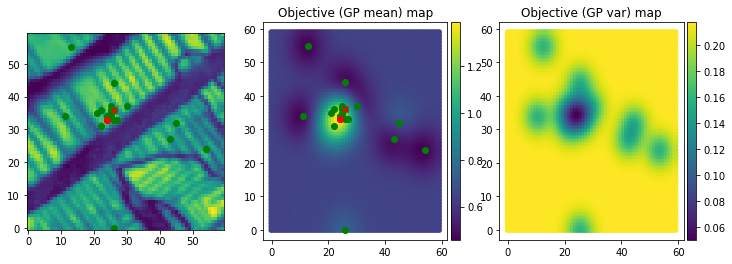

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#Initialize for BO
num_start = 5  # Starting samples
N= 15

#latent parameters for defining KL trajectories
grid_x1 = torch.arange(0, bepfm_lowres_image.shape[0])
grid_x2 = torch.arange(0, bepfm_lowres_image.shape[1])

X= torch.vstack((grid_x1, grid_x2))

#Fixed parameters of VAE model
fix_params = [loop_norm, bepfm_lowres_image, V]

#BO
X_opt, X_opt_GP, var_params, explored_locs, final_GP_estim = BO_vartarget(X, fix_params, num_start, N)

Plot optimal spectrals as per user voted

tensor([[26., 36.]]) tensor([[24., 33.]])


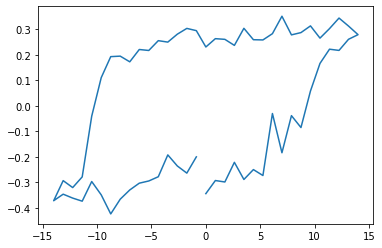

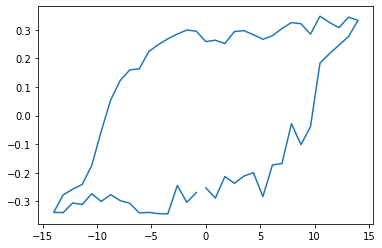

In [ ]:
print(X_opt, X_opt_GP)
#Optimal from estimated GP
plt.plot(V, loop_norm[int(X_opt_GP[0, 0]),int(X_opt_GP[0, 1]),:])
plt.show()

#Optimal from evaluated samples
plt.plot(V, loop_norm[int(X_opt[0, 0]), int(X_opt[0, 1]),:])
plt.show()

# Lets try with a different data- IV data

In [ ]:
!pip install -U gdown
!gdown "https://drive.google.com/uc?id=1l9-i36puXUcGXQMGSgVjci_x-aNC4bzp"
!gdown "https://drive.google.com/uc?id=1-YMtG0kjypcmVvJDJwaJ1QUf5Ar32uj-"

iv_dat = np.load("cur_mat_raw.npy")
iv_dat = iv_dat
dc_vec = np.load("cur_mat_vdc.npy")




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1l9-i36puXUcGXQMGSgVjci_x-aNC4bzp
To: /content/cur_mat_vdc.npy
100% 1.15k/1.15k [00:00<00:00, 1.39MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-YMtG0kjypcmVvJDJwaJ1QUf5Ar32uj-
To: /content/cur_mat_raw.npy
100% 2.56M/2.56M [00:00<00:00, 186MB/s]


# Run below hidden cell for data preparation to start BO

In [ ]:
#@title

#print(iv_dat.shape)
iv_dat = iv_dat.reshape(50,50,iv_dat.shape[1])*1e11
V= dc_vec
#print(iv_dat.shape)
#print(V.shape)

#Generate the grid param space (taking means of spectral values at each grid location)
iv_lowres_image = np.mean(iv_dat, axis=2)
iv_lowres_image = np.transpose(iv_lowres_image)
#print(iv_lowres_image.shape)
#plt.figure()
#plt.imshow(iv_lowres_image, origin="lower")
#plt.colorbar()

#Normalize loop data (avoiding drift in data)
iv_norm = np.zeros((iv_dat.shape))
for i in range(0, iv_dat.shape[0]):
  for j in range(0, iv_dat.shape[1]):
    iv_norm[i, j, :] = (iv_dat[i,j,:]- np.mean(iv_dat[i,j,:]))

#print(iv_dat.shape, iv_norm.shape)

#tranform data into torch
iv_norm = torch.from_numpy(iv_norm)
V = torch.from_numpy(V)
iv_lowres_image= torch.from_numpy(iv_lowres_image)

#print(iv_norm.shape, iv_lowres_image.shape, V.shape)

Run BO to find the optimal location for best spectral as voted by user

- Here we vote the quality of spectral as trying to get as much as smoother curves and increasing values with evolution.

Sample #1


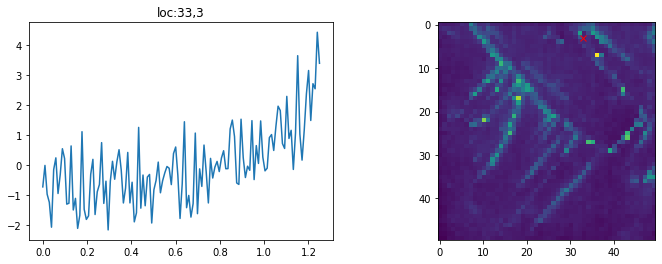

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Sample #2


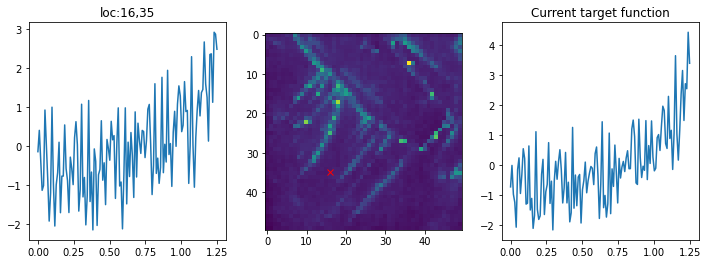

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #3


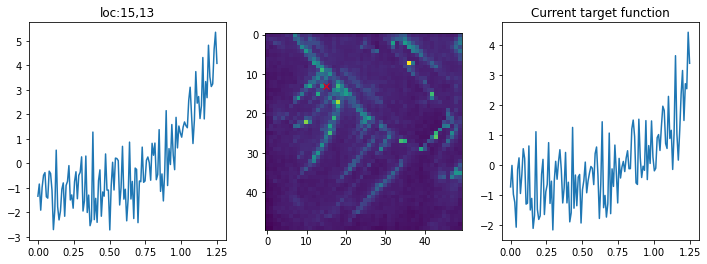

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #4


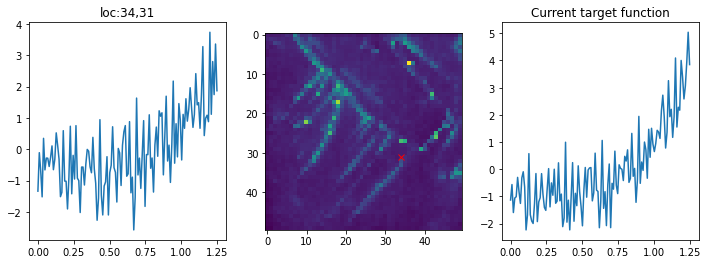

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #5


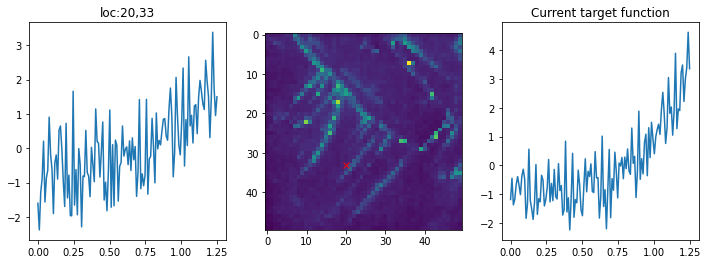

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Initial evaluation complete. Start BO


/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


<Figure size 432x288 with 0 Axes>

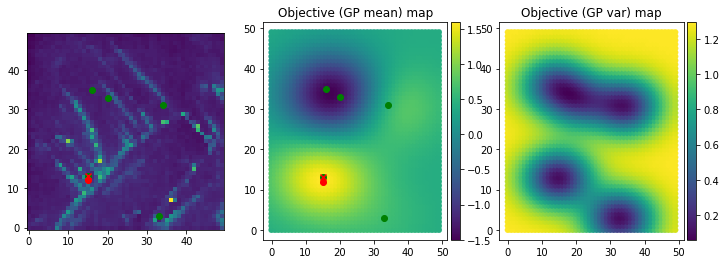

Sample #6


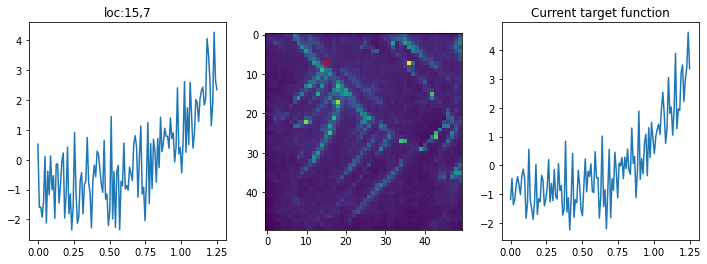

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #7


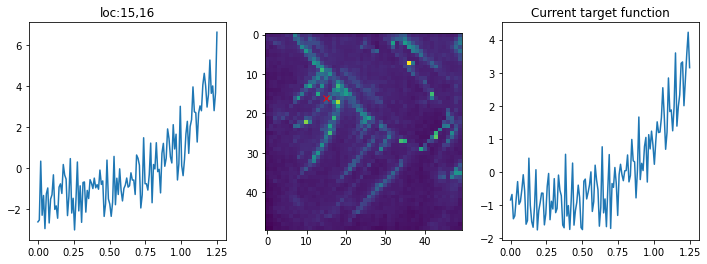

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 1
Sample #8


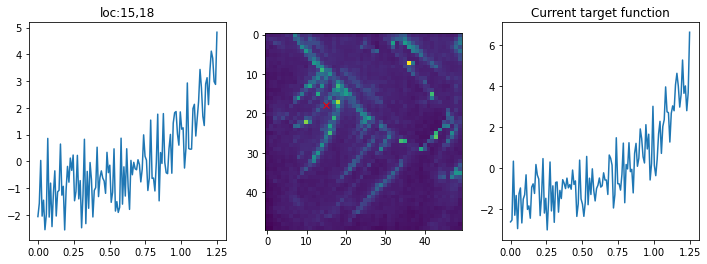

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #9


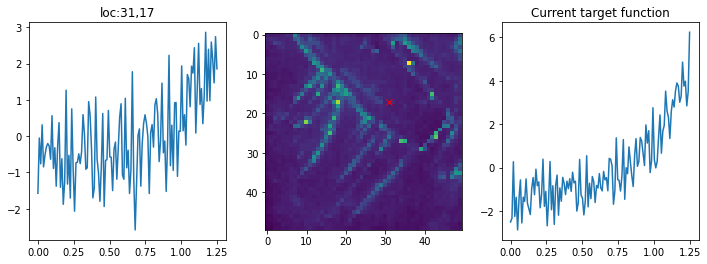

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #10


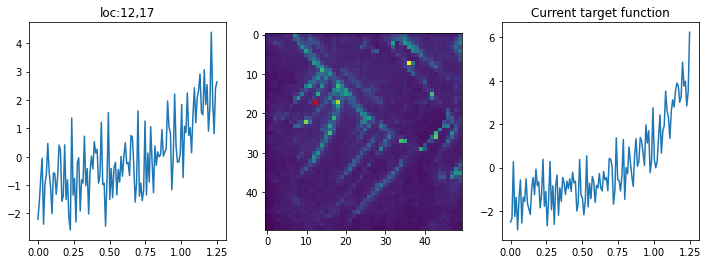

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #11


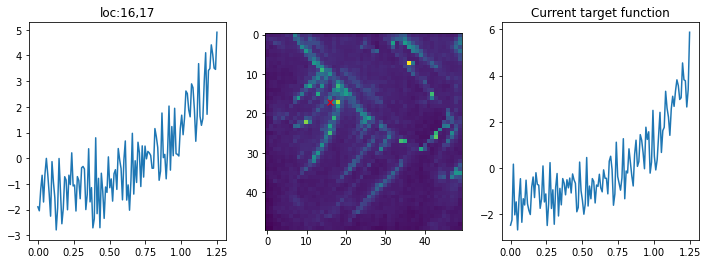

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #12


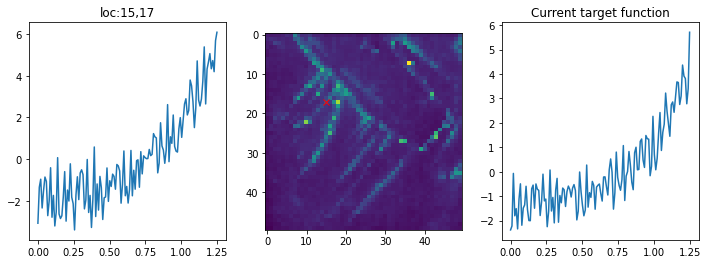

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #13


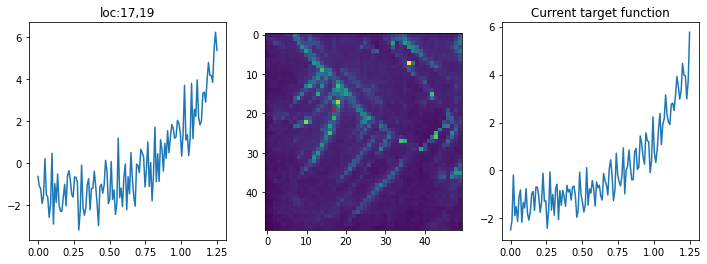

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #14


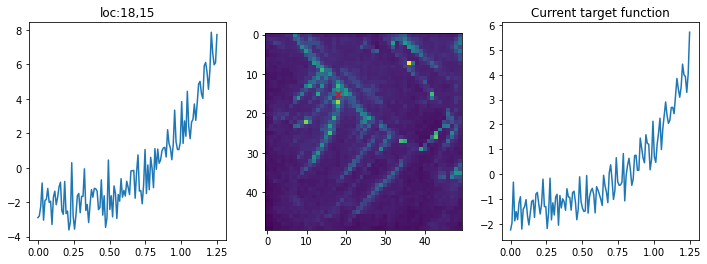

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N


<Figure size 432x288 with 0 Axes>

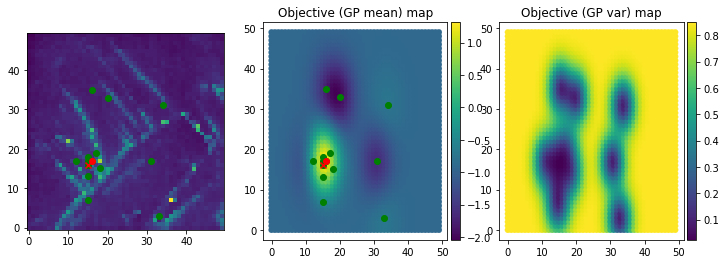

Sample #15


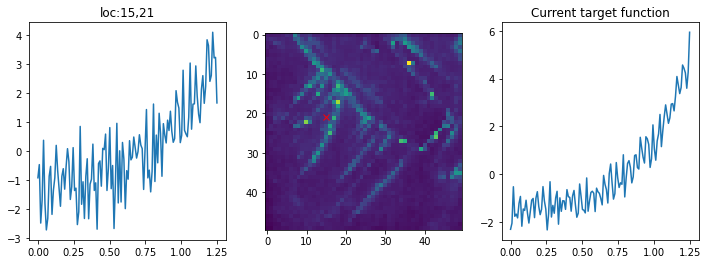

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #16


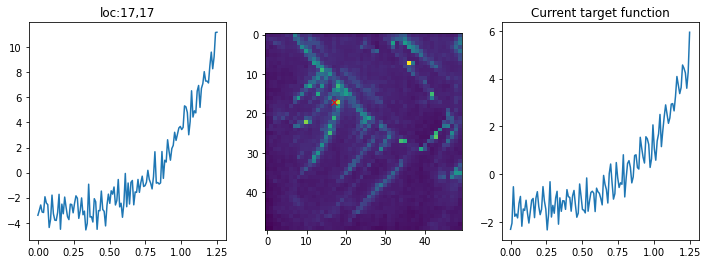

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #17


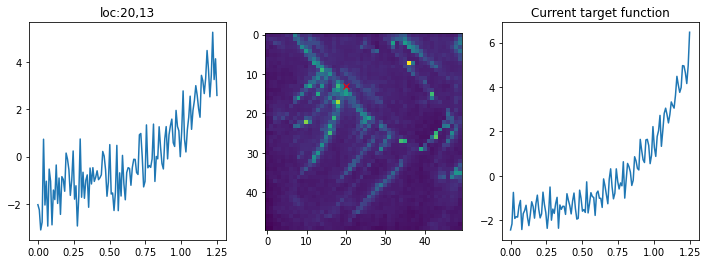

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #18


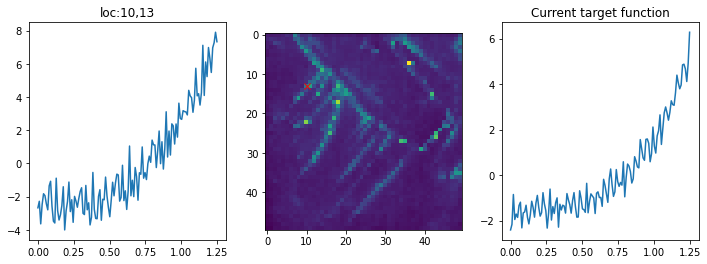

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #19


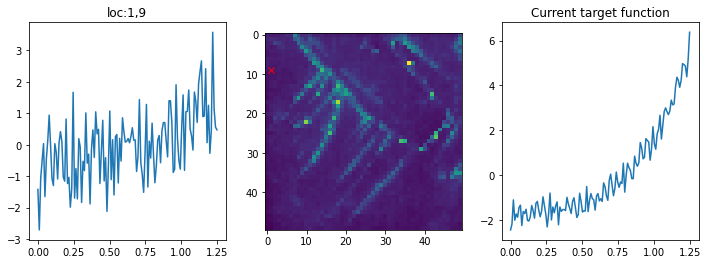

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #20


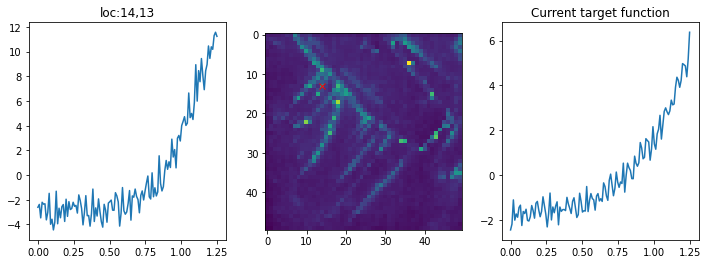

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 1
Sample #21


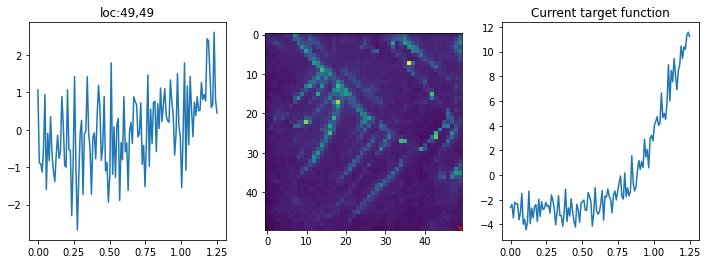

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #22


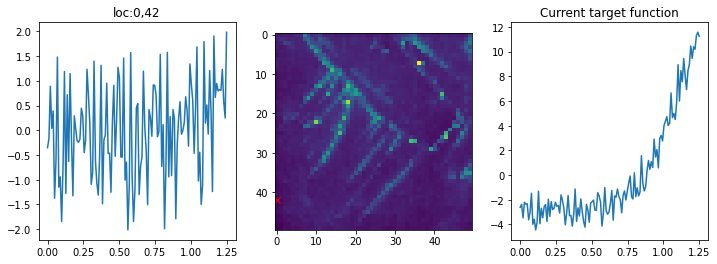

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #23


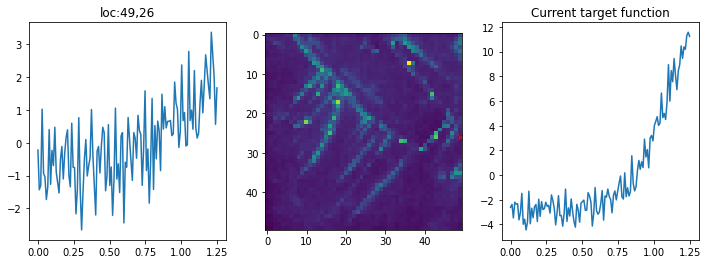

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #24


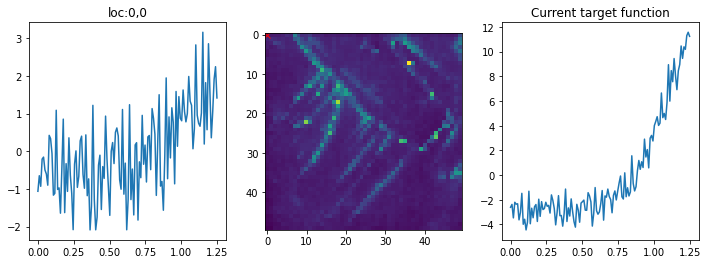

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

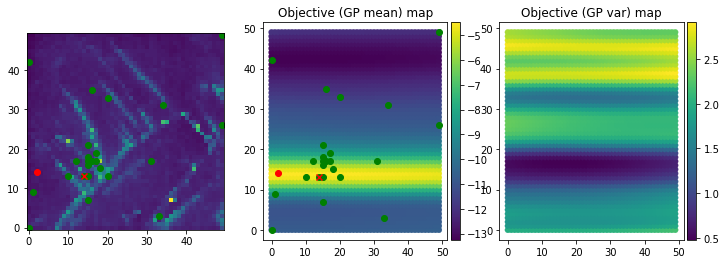

Sample #25


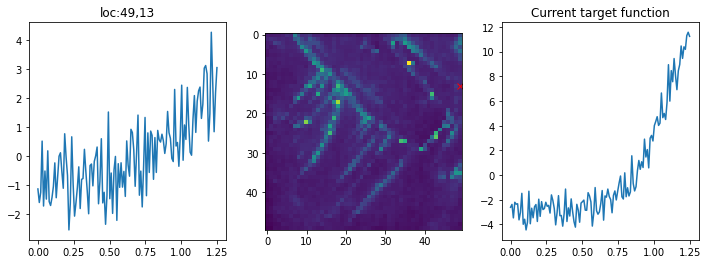

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #26


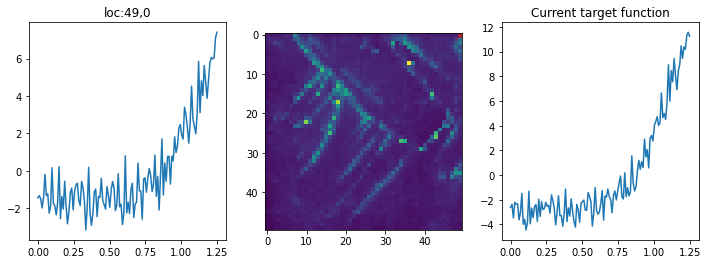

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #27


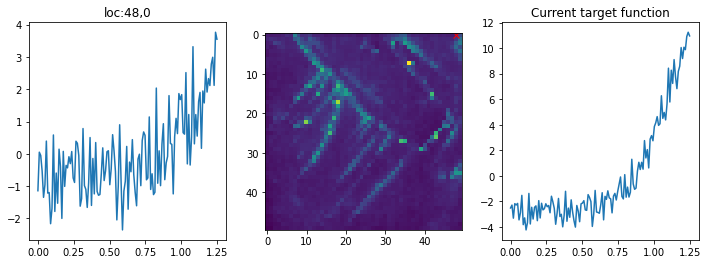

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #28


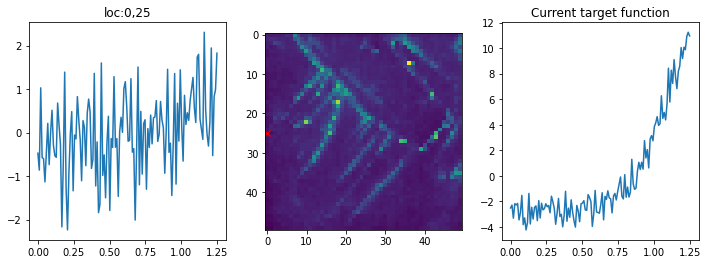

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #29


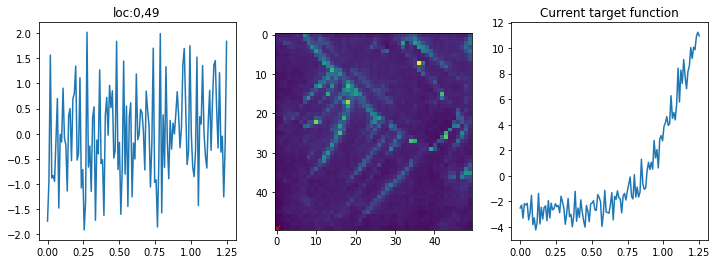

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #30


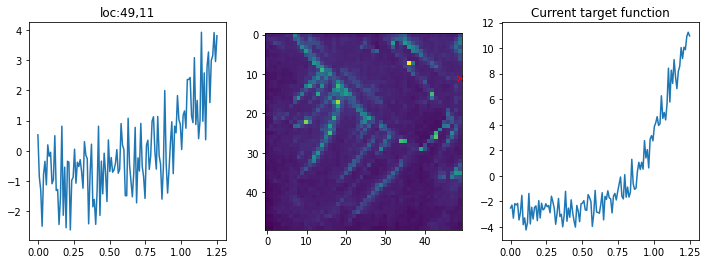

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #31


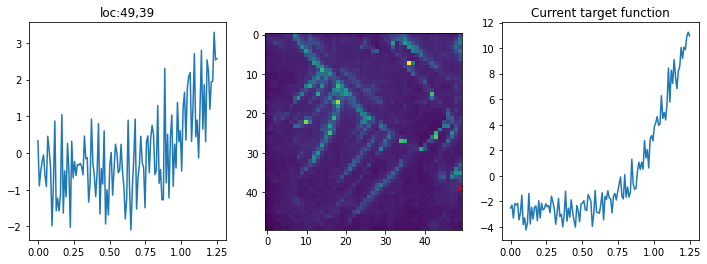

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #32


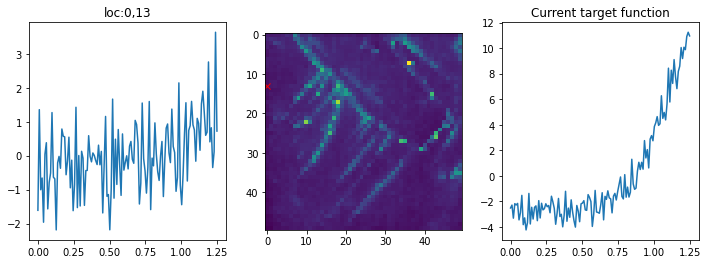

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #33


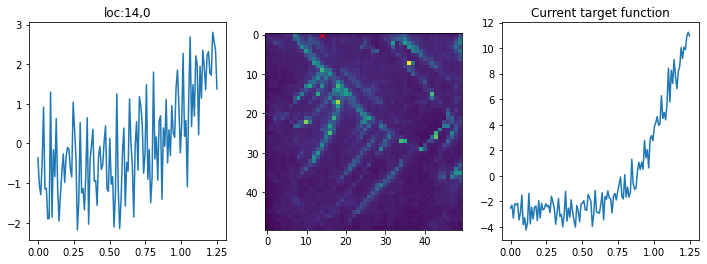

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #34


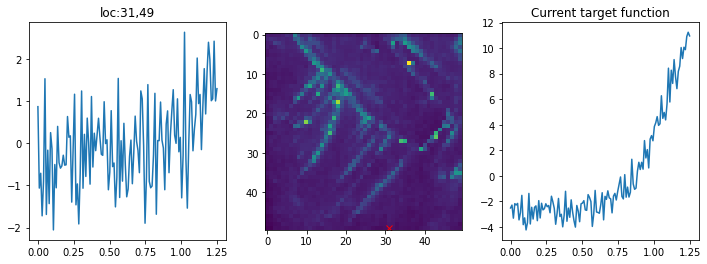

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

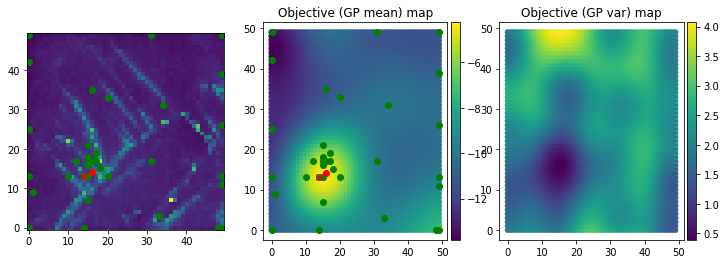

Sample #35


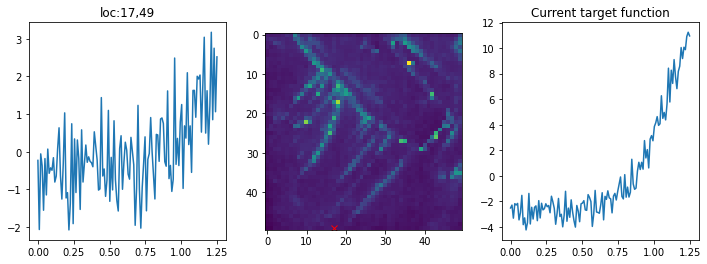

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #36


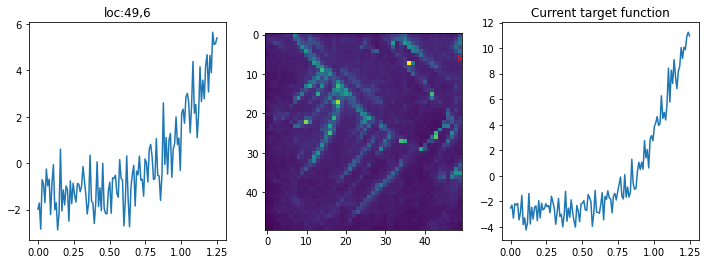

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #37


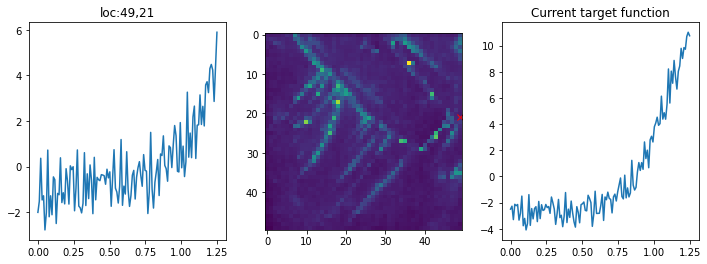

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #38


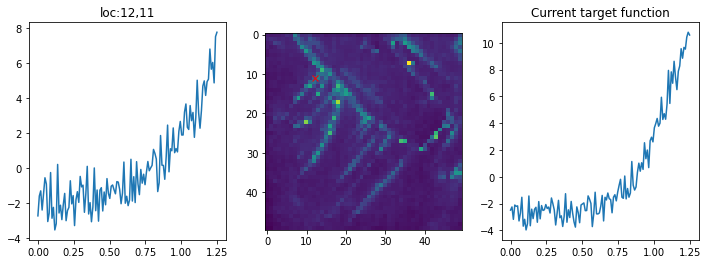

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #39


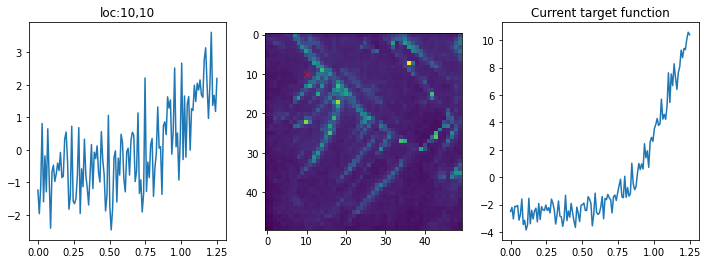

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #40


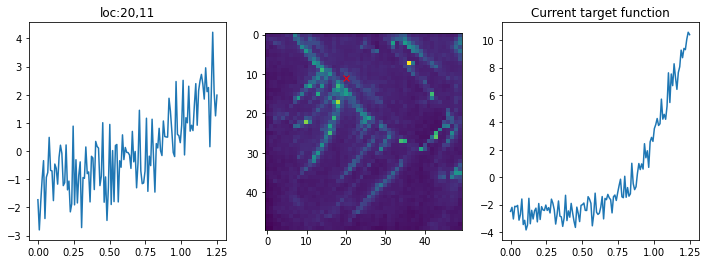

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #41


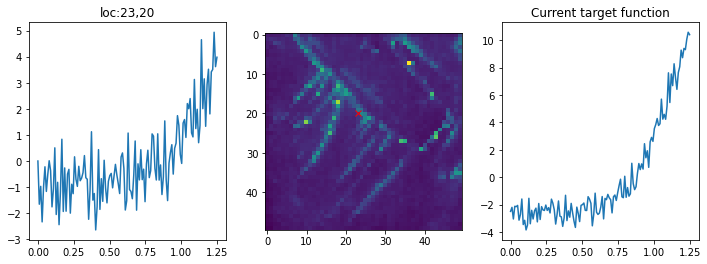

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #42


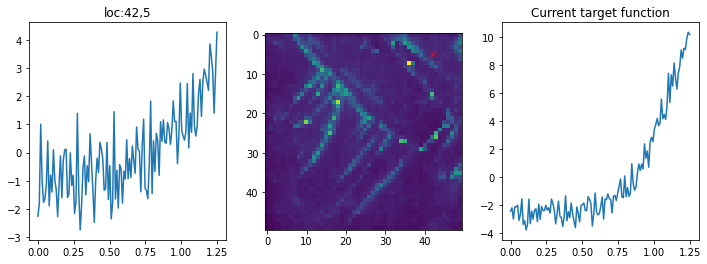

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #43


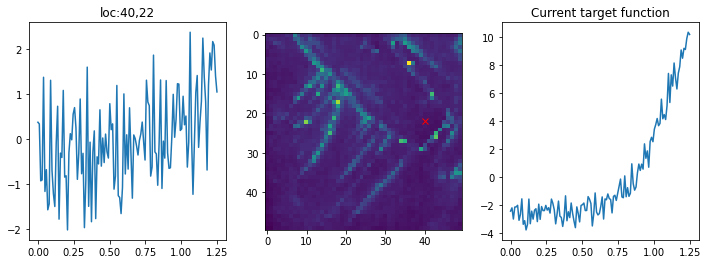

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #44


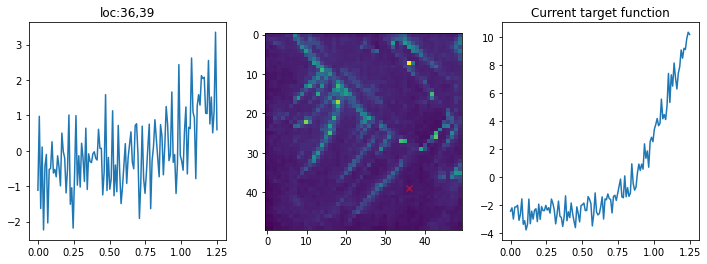

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

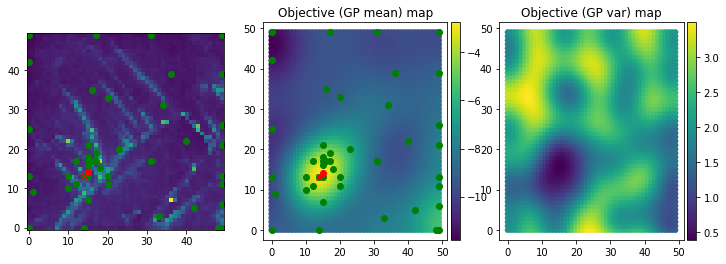

Sample #45


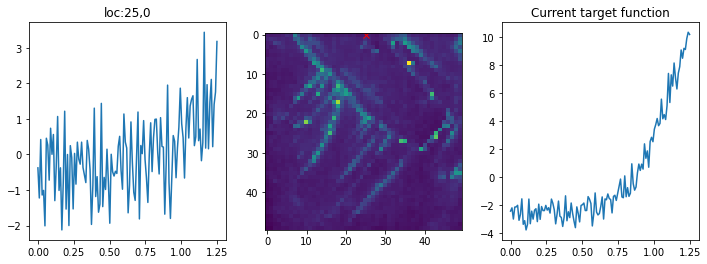

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #46


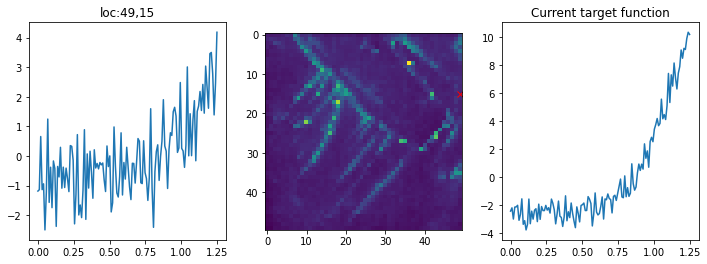

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #47


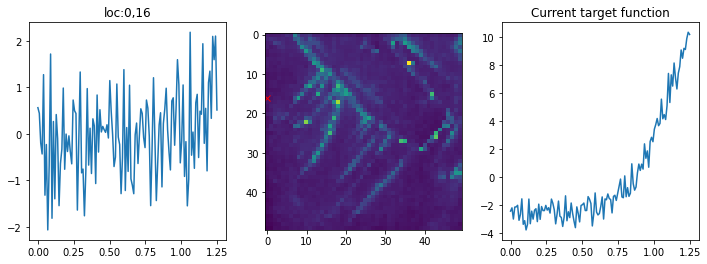

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #48


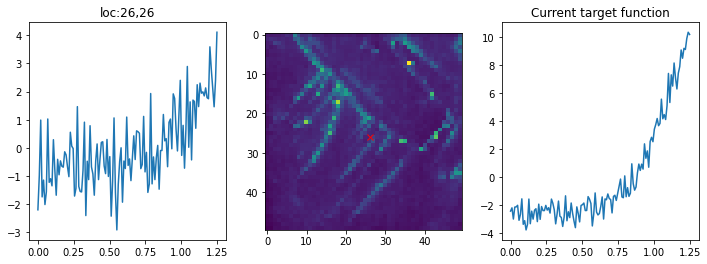

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #49


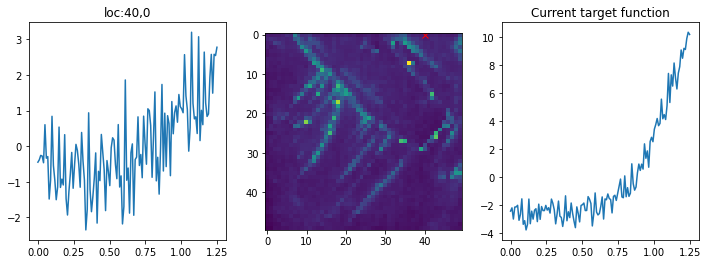

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #50


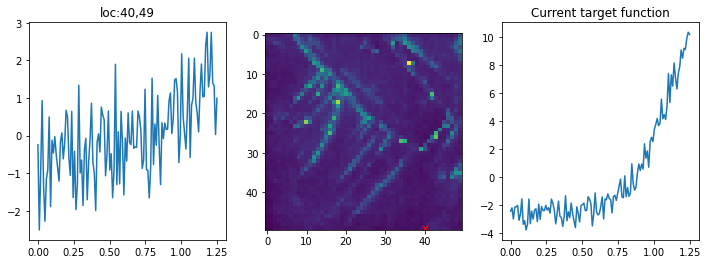

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #51


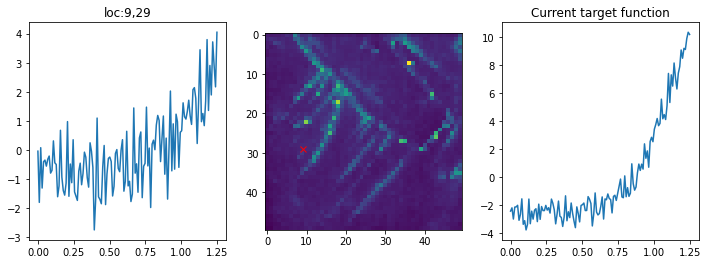

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #52


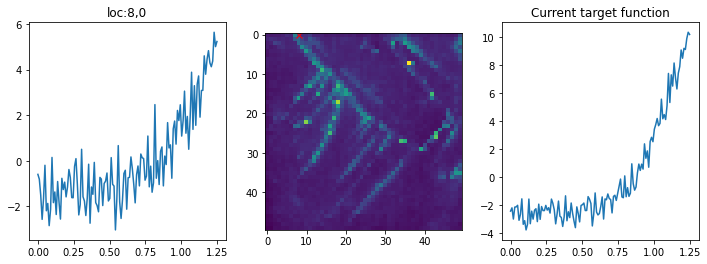

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #53


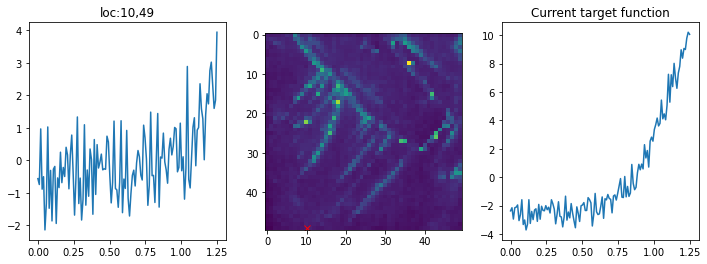

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #54


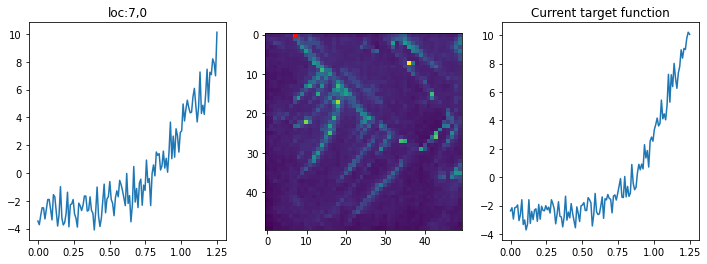

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N


<Figure size 432x288 with 0 Axes>

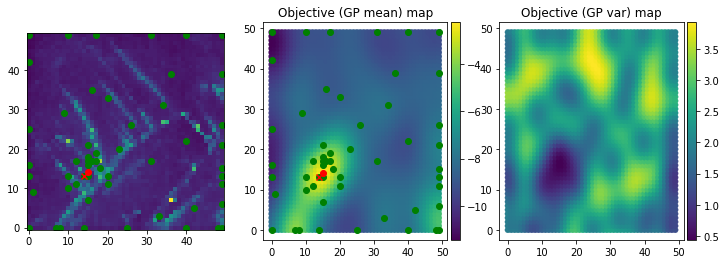

Sample #55


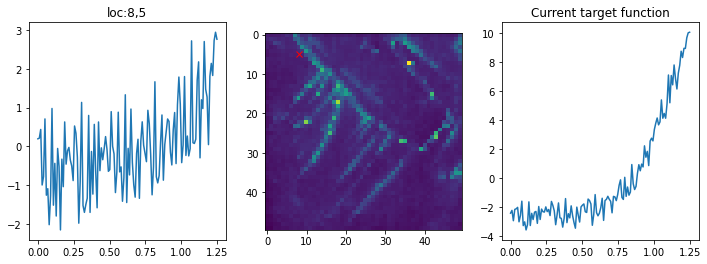

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #56


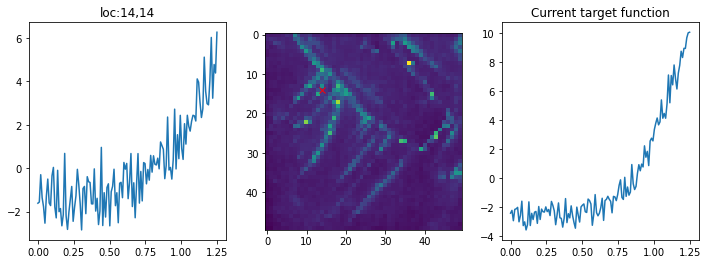

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #57


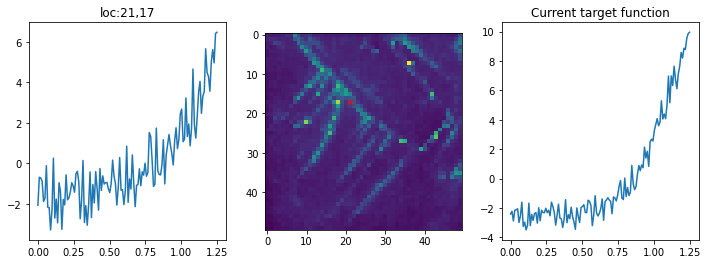

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #58


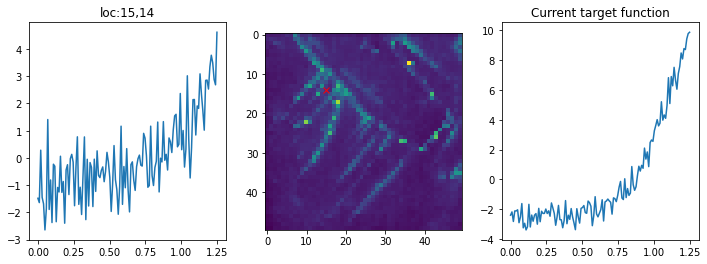

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #59


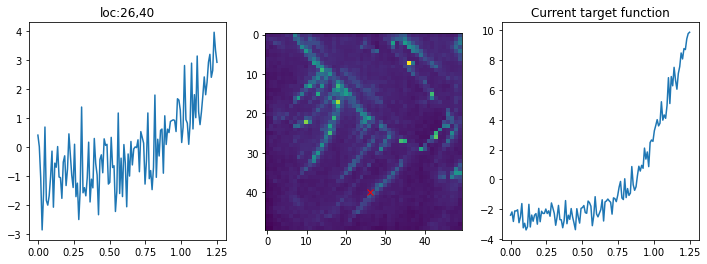

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #60


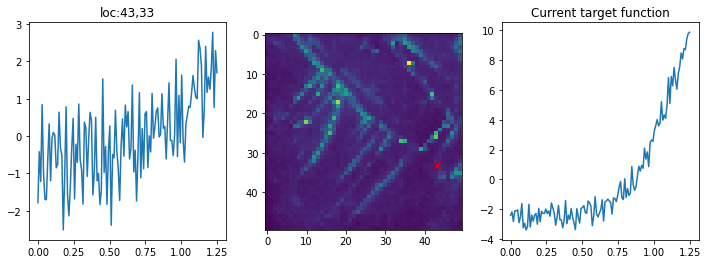

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #61


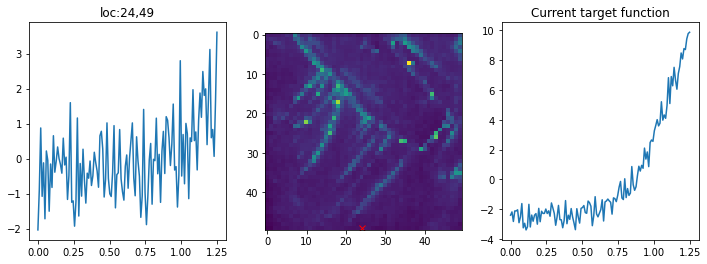

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #62


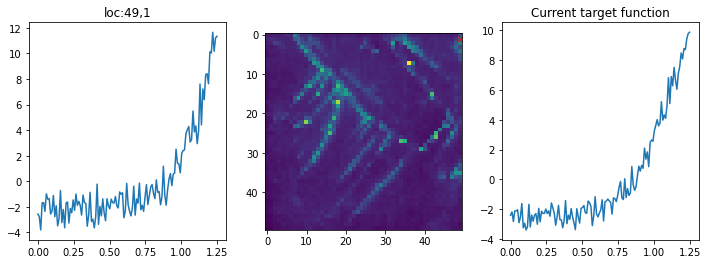

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #63


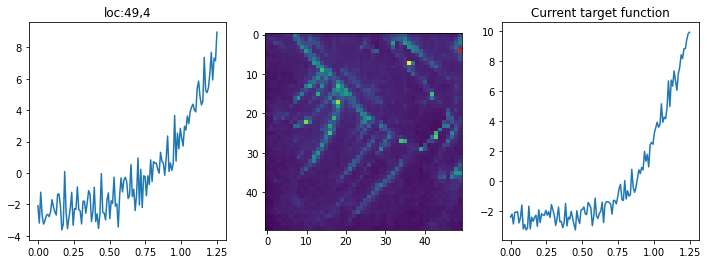

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #64


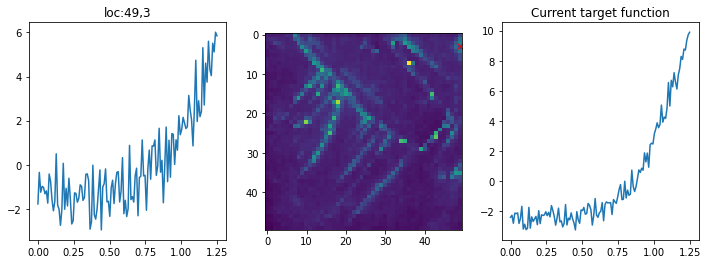

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N


<Figure size 432x288 with 0 Axes>

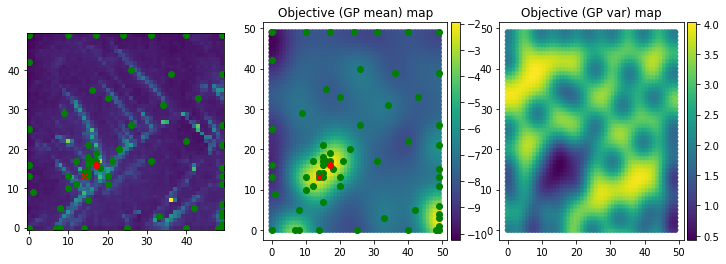

Sample #65


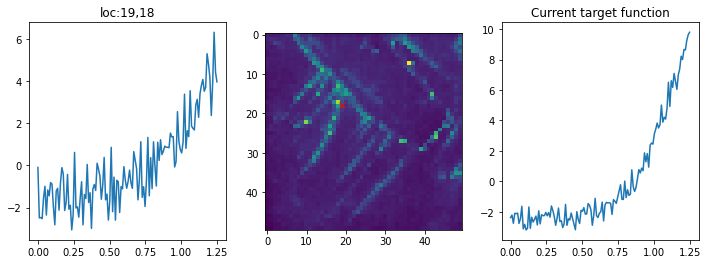

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #66


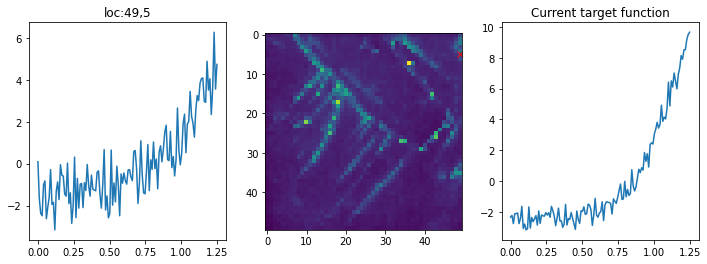

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #67


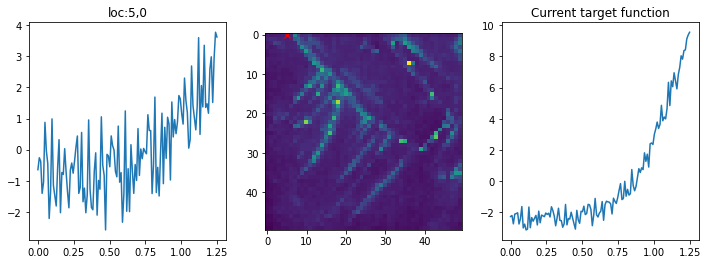

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #68


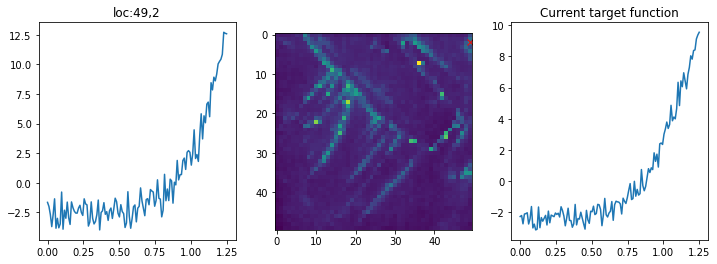

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #69


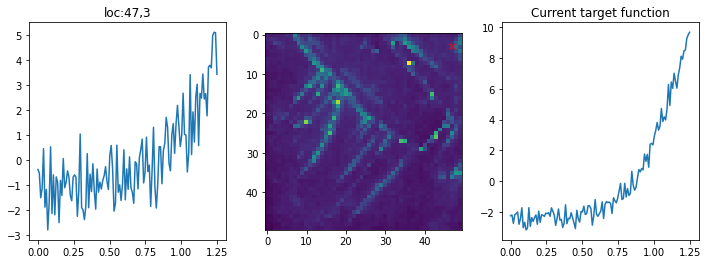

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #70


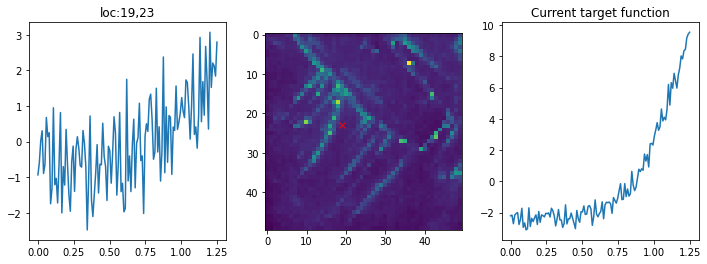

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #71


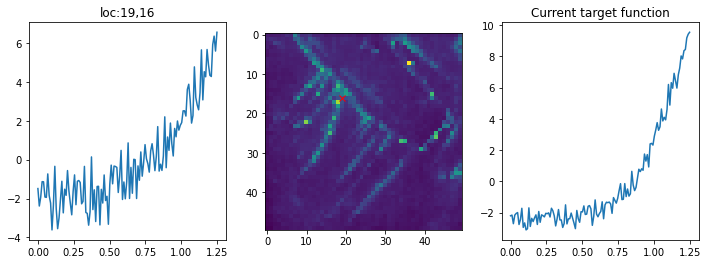

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #72


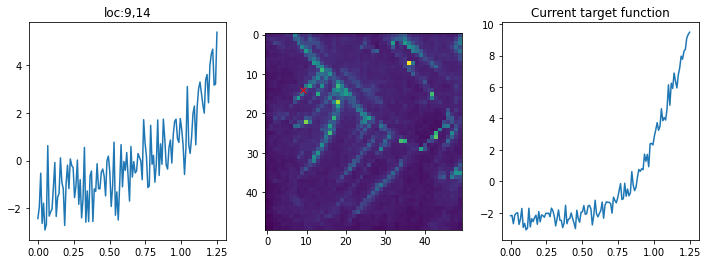

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #73


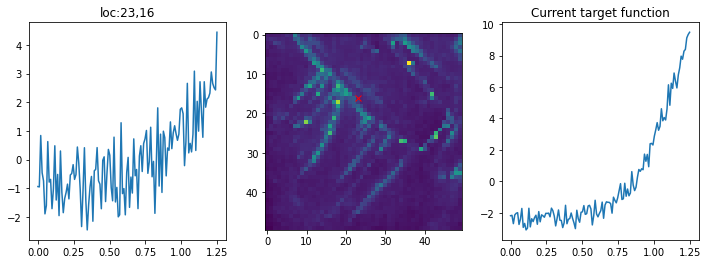

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #74


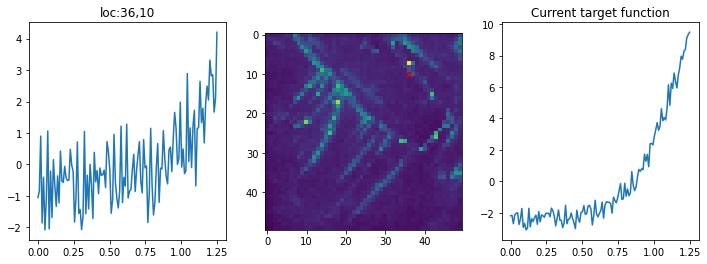

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

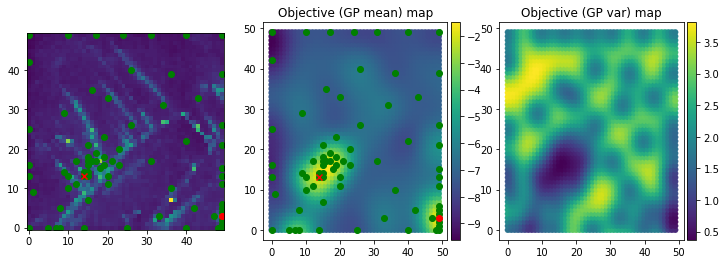

Sample #75


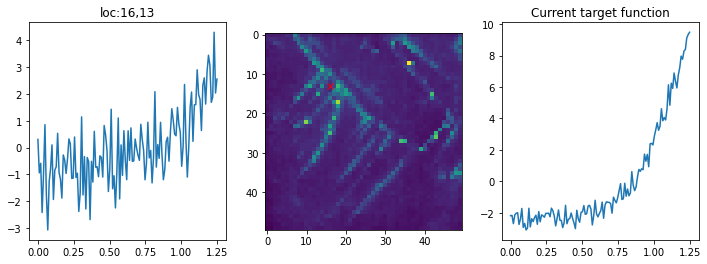

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #76


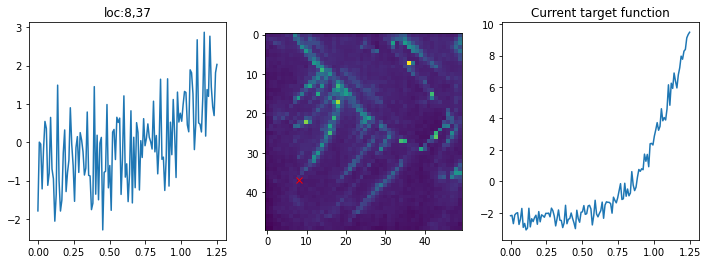

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #77


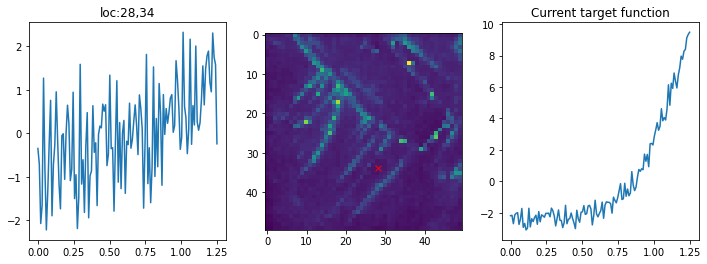

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #78


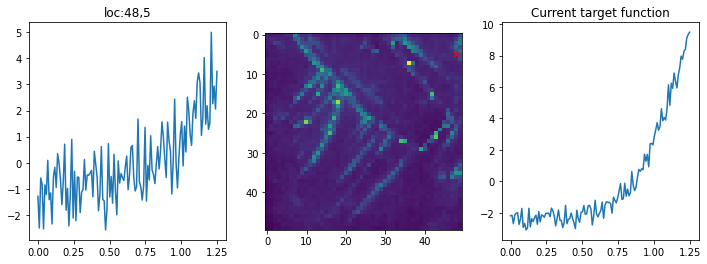

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #79


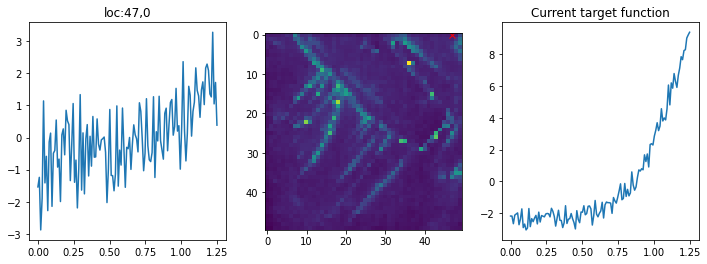

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #80


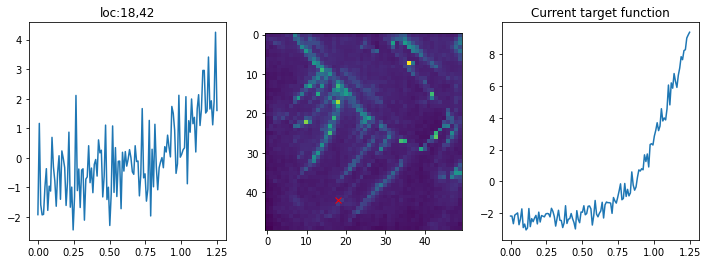

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #81


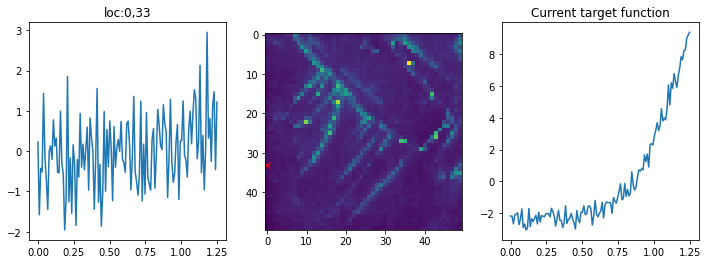

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #82


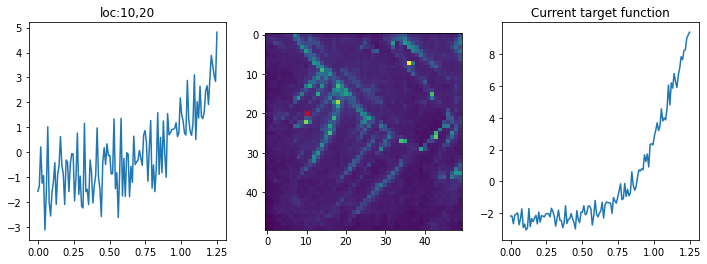

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #83


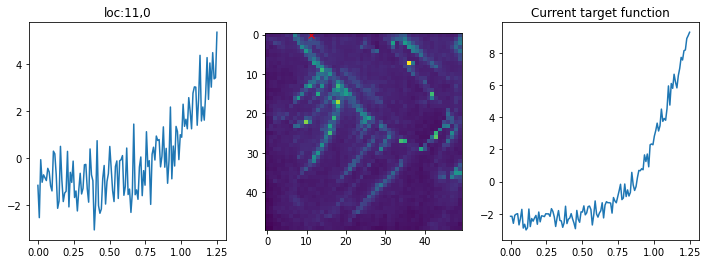

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #84


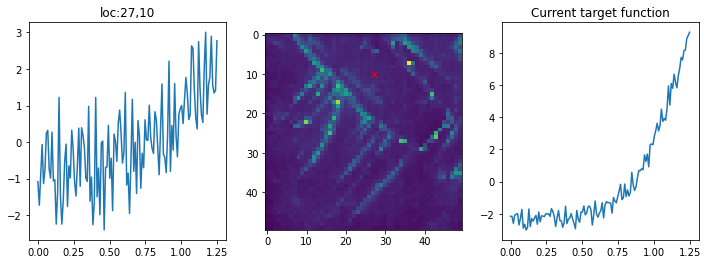

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

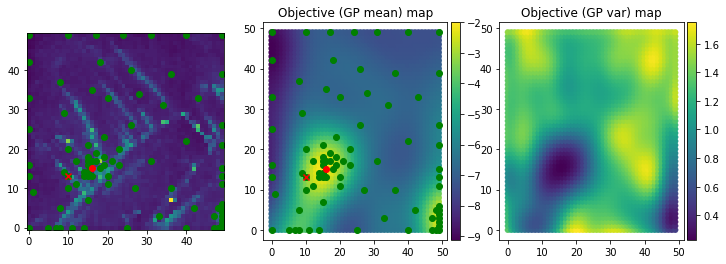

Sample #85


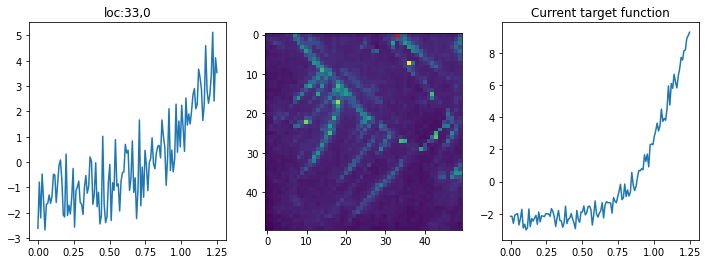

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 0.01
Sample #86


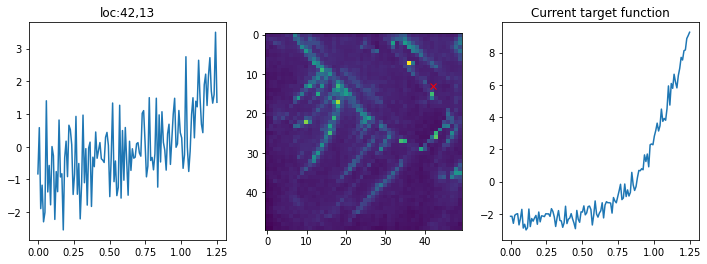

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #87


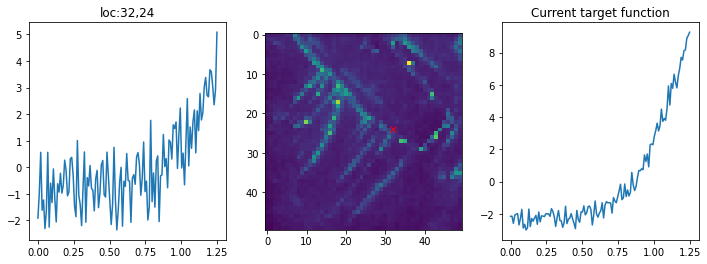

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 0.01
Sample #88


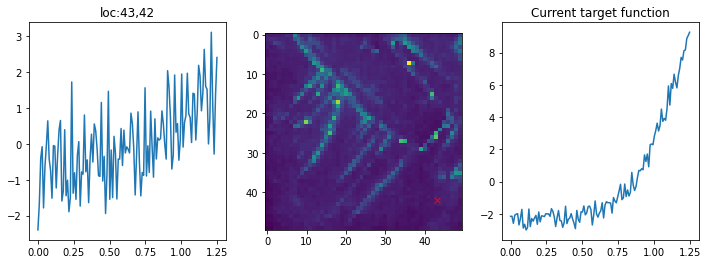

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #89


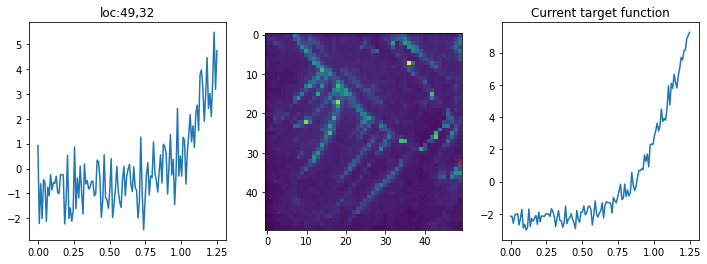

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 0.01
Sample #90


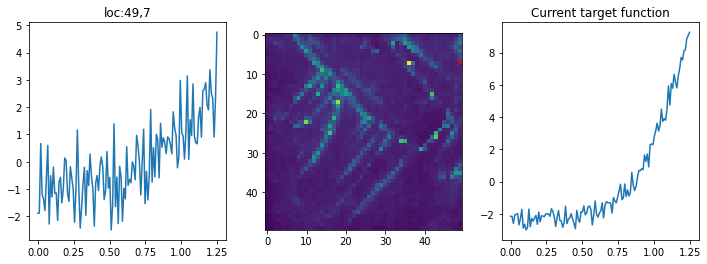

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #91


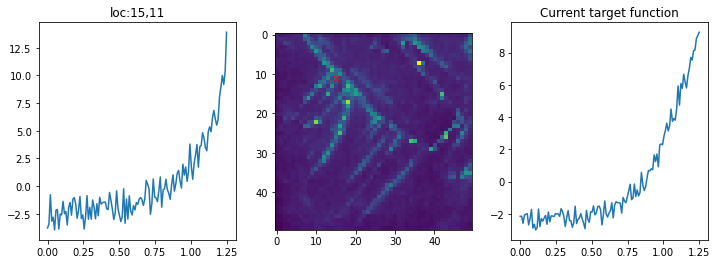

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #92


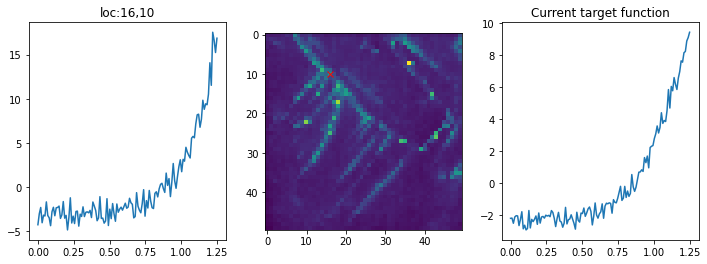

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #93


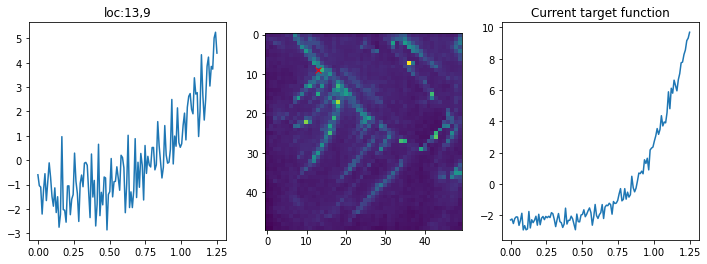

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): Y
Provide weights between 0 and 1: 1 being all the weights to new spectral as new target
enter weightage: 0.01
Sample #94


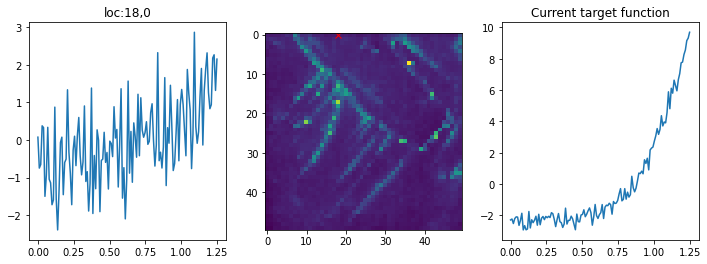

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

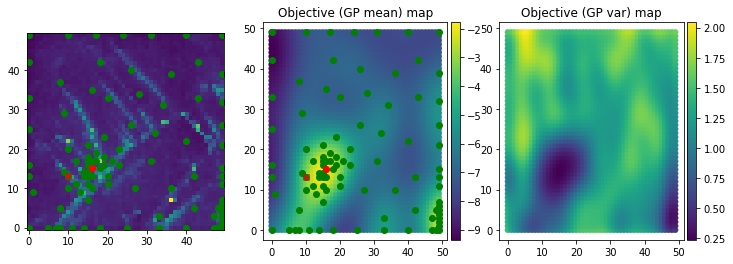

Sample #95


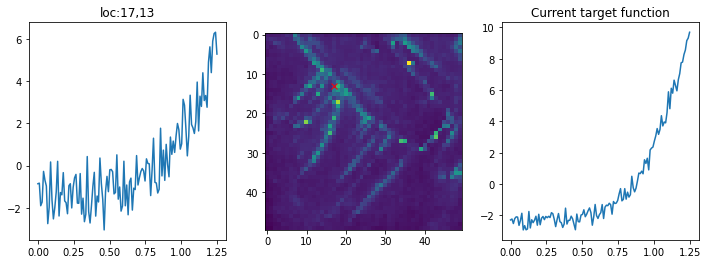

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #96


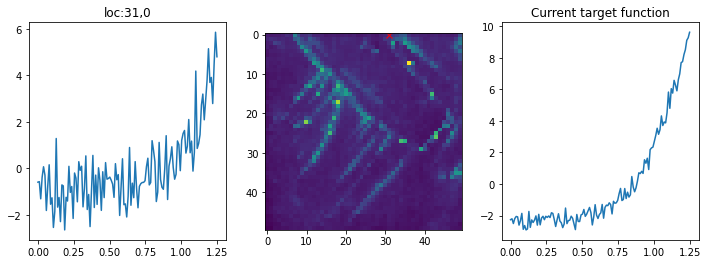

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 1
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #97


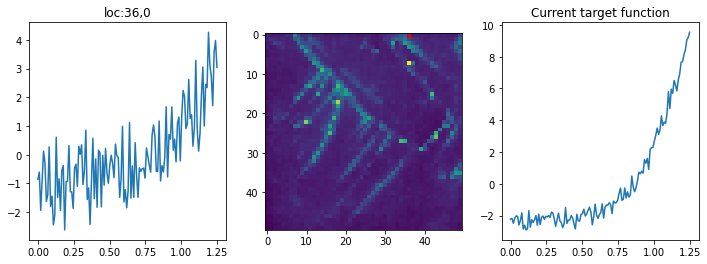

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #98


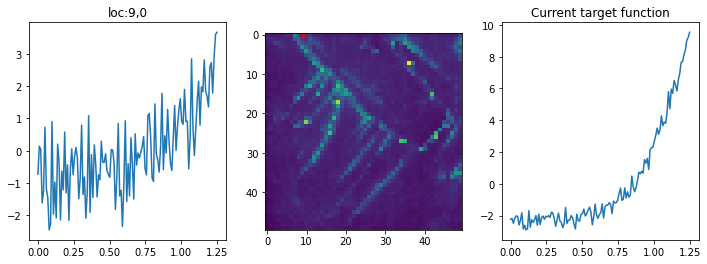

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #99


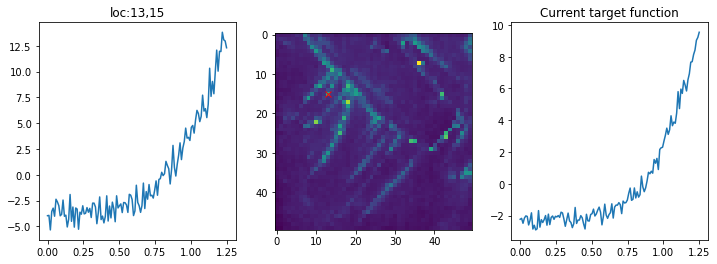

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 2
Do you want to update preference to new spectral over prioir mean target (Y/N): N
Sample #100


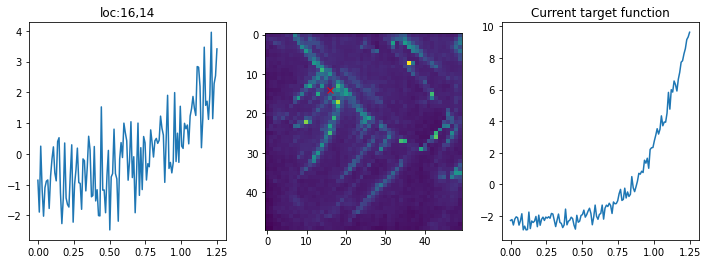

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #101


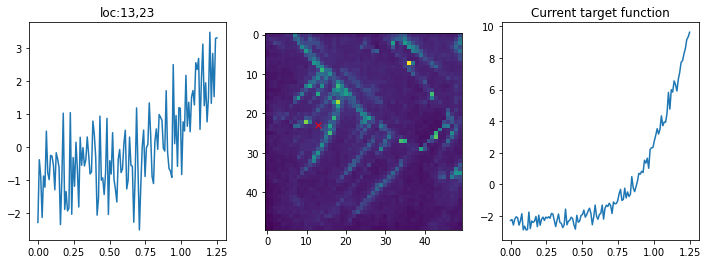

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #102


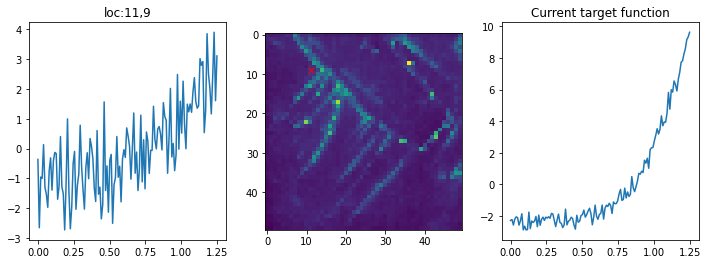

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #103


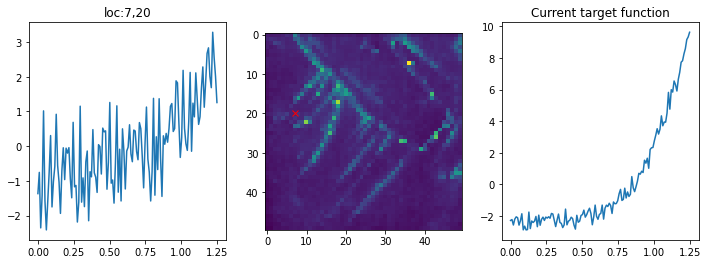

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Sample #104


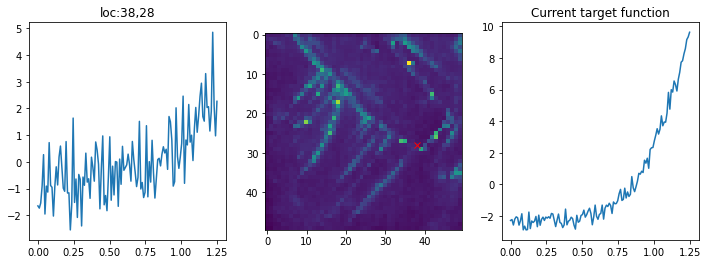

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0


<Figure size 432x288 with 0 Axes>

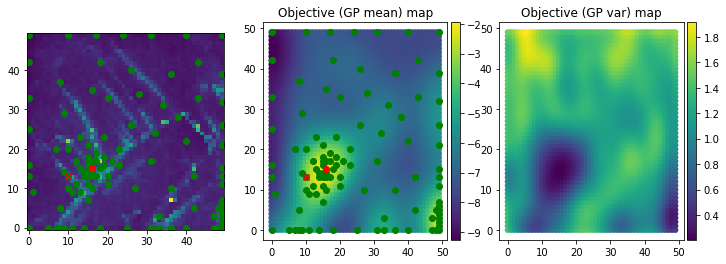

Sample #105


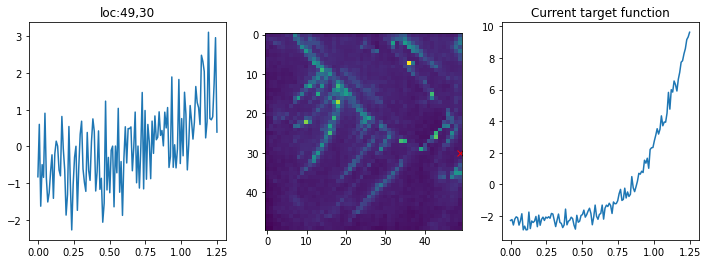

Rating: 0-Bad, 1-Good, 2-Very good
enter rating: 0
Max. sampling reached, model stopped


<Figure size 432x288 with 0 Axes>

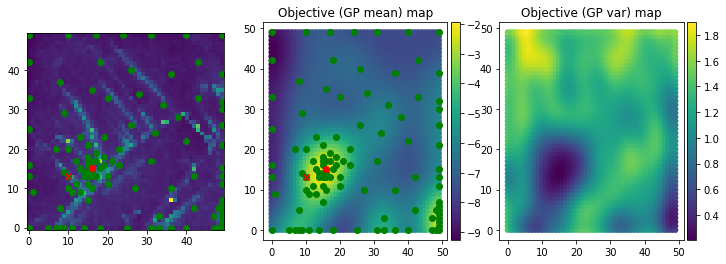

In [ ]:
1#Initialize for BO
num_start = 5  # Starting samples
N= 100

#latent parameters for defining KL trajectories
grid_x1 = torch.arange(0, iv_lowres_image.shape[0])
grid_x2 = torch.arange(0, iv_lowres_image.shape[1])

X= torch.vstack((grid_x1, grid_x2))

#Fixed parameters of VAE model
fix_params = [iv_norm, iv_lowres_image, V]

#BO
X_opt, X_opt_GP, var_params, explored_locs, final_GP_estim = BO_vartarget(X, fix_params, num_start, N)

tensor([[10., 13.]]) tensor([[16., 15.]])


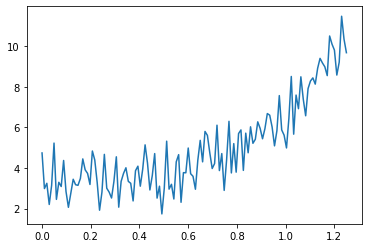

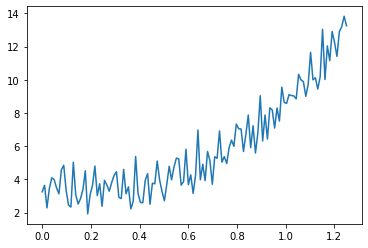

In [ ]:
print(X_opt, X_opt_GP)
#Optimal from estimated GP
plt.plot(V, iv_dat[int(X_opt_GP[0, 0]),int(X_opt_GP[0, 1]),:])
plt.show()

#Optimal from evaluated samples
plt.plot(V, iv_dat[int(X_opt[0, 0]), int(X_opt[0, 1]),:])
plt.show()